12/11/2021

Rebin HST UV spectra from Sulentic+2007 and combine with their SDSS optical data where available.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from os.path import exists

import sys
sys.path.append("/Volumes/MyPassportforMac/HST/AllHSTCode/")
import Read_FOS_TVM
import Read_STIS_TVM
import Read_COS_TVM

In [2]:
def isNaN(string):
    return string != string

In [3]:
!ls ../../AllData/SulenticAllData

COS                                   Sulentic2007Info.fit
FOS                                   Sulentic2007Info_wpaths.csv
FinalPlots                            Sulentic2007Tables1_2.classicalRM.fit
OtherOpt                              Sulentic2007Tables1_2.fit
SDSS                                  notes_sulentic_tvm.txt
STIS                                  speclist_sdss_sulentic07.txt
Sulentic2007Info.csv                  sulentic_targets.ipynb


In [4]:
sul = pd.read_csv("../../AllData/SulenticAllData/Sulentic2007Info_wpaths.csv")
sul

IAU    Instrument     FOS_Name    STIS_Name     COS_Name HST_Opt  \
0    J00392-5117       COS+FOS  J00392-5117         None  J00392-5117     FOS   
1    J00535+1241       COS+FOS  J00535+1241         None  J00535+1241     NaN   
2    J16279+5522       COS+FOS  J16279+5522         None  J16279+5522     FOS   
3    J22540-1734           COS         None         None   MR2251-178     NaN   
4    J12258+3332      COS+STIS         None      NGC4395      NGC4395    STIS   
..           ...           ...          ...          ...          ...     ...   
125  J10040+2855       COS+FOS   PG1001+291         None   PG1001+291     NaN   
126  J10518-0051       COS+FOS   PG1049-005         None   PG1049-005     NaN   
127  J11246+4201       COS+FOS   PG1121+422         None   PG1121+422     NaN   
128  J12193+0638       COS+FOS   PG1216+069         None   PG1216+069     NaN   
129  J13012+5902  COS+FOS+STIS  SBS1259+593  SBS1259+593   PG1259+593     NaN   

          z  Hbeta  F1550  FCIVNC  ...         _RA        _DE  SDSS Spectra  \
0    0.0290   1203   0.20     NaN  ...    9.816096 -51.283717           yes   
1    0.0605   1151   3.25     NaN  ...   13.395549  12.693386           yes   
2    0.1326   4888   2.06    0.40  ...  246.983750  55.375444           yes   
3    0.0638   7176   2.50     NaN  ...  343.524566 -17.581972           yes   
4    0.0008   1695   0.24    1.25  ...  186.453842  33.546750           yes   
..      ...    ...    ...     ...  ...         ...        ...           ...   
125  0.3298   1853   2.07    0.00  ...  151.010903  28.926500           yes   
126  0.3591   5610   1.44    0.36  ...  162.964335  -0.854926           yes   
127  0.2253   2834   1.52    0.25  ...  171.163228  42.029178           yes   
128  0.3322   7072   1.79    1.50  ...  184.837217   6.644021            no   
129  0.4776   3569   2.40    0.00  ...  195.303819  59.035190           yes   

              SDSS_NAME          RA        DEC    PLATE      MJD  FIBERID  \
0                   NaN         NaN        NaN      NaN      NaN      NaN   
1                   NaN         NaN        NaN      NaN      NaN      NaN   
2                   NaN         NaN        NaN      NaN      NaN      NaN   
3                   NaN         NaN        NaN      NaN      NaN      NaN   
4                   NaN         NaN        NaN      NaN      NaN      NaN   
..                  ...         ...        ...      ...      ...      ...   
125  100402.60+285535.3  151.010865  28.926487  10449.0  58137.0    658.0   
126  105151.44-005117.6  162.964345  -0.854905    276.0  51909.0    251.0   
127  112439.18+420145.0  171.163263  42.029172   1443.0  53055.0    358.0   
128                 NaN         NaN        NaN      NaN      NaN      NaN   
129  130112.91+590206.6  195.303822  59.035185    957.0  52398.0     20.0   

     Separation  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
125    0.127722  
126    0.084093  
127    0.095954  
128         NaN  
129    0.017950  

[130 rows x 29 columns]

In [5]:
z       = sul["z"].values
sdss    = ~isNaN(sul["SDSS_NAME"].values)
plate   = sul["PLATE"].values
mjd     = sul["MJD"].values
fiber   = sul["FIBERID"].values
id_fos  = sul["FOS_Name"].values
id_stis = sul["STIS_Name"].values
id_cos = sul["COS_Name"].values

In [6]:
FOS  = sul["FOS_Name"].values!="None"
STIS = sul["STIS_Name"].values!="None"
COS  = sul["COS_Name"].values!="None"
(FOS&sdss).sum(), (STIS&sdss).sum(), (COS&sdss).sum(), ((FOS|STIS|COS)&sdss).sum()

(52, 5, 4, 53)

In [7]:
id_cos[(COS&sdss)]

array(['PG1001+291', 'PG1049-005', 'PG1121+422', 'PG1259+593'],
      dtype=object)

There is one Sulentic source that only has COS data.  Will worry about that as I collect more DR16 sources for the full sample.

For now the sample I'll work with is those with either FOS or STIS data, and which have SDSS-DR16 data as well.  This gives 53 Sulentic quasars.

In [8]:
#Check if we have NecessaryParams.csv file saved for each 
N = 0
for i in range(sul[FOS].shape[0]):
    if not exists("/Volumes/MyPassportforMac/HST/AllData/SulenticAllData/FOS/%s/NecessaryParams.csv" % id_fos[FOS][i]):
        N += 1
        print("Missing HST Observational Params for %s" % id_fos[FOS][i])
    #Read_FOS_TVM.rebin(id_fos[FOS][i], "%04d/spec-%04d-%05d-%04d.fits"%(plate[FOS][i],mjd[FOS][i],fiber[FOS][i]), z[FOS][i])
    
    
N

0

Good, should be ready to test all FOS-Sulentic spectra.  Now same thing for STIS and COS.

In [9]:
#Check if we have NecessaryParams.csv file saved for each 
N = 0
for i in range(sul[STIS].shape[0]):
    if not exists("/Volumes/MyPassportforMac/HST/AllData/SulenticAllData/STIS/%s/NecessaryParams.csv" % id_stis[STIS][i]):
        N += 1
        print("Missing HST Observational Params for %s" % id_stis[STIS][i])
    #Read_STIS_TVM.rebin(id_stis[STIS][i], "%04d/spec-%04d-%05d-%04d.fits"%(plate[STIS][i],mjd[STIS][i],fiber[STIS][i]), z[STIS][i])
    
    
N

0

Finally.  Now the COS sources.  Should be able to use the ``all_exposures.txt`` files, but I'm not sure where they came from, so it would be tricky to fill in for those that don't have.

In [10]:
#Check if we have NecessaryParams.csv file saved for each 
N = 0
for i in range(sul[COS].shape[0]):
    if not exists("/Volumes/MyPassportforMac/HST/AllData/SulenticAllData/COS/%s/all_exposures.txt" % id_cos[COS][i]):
        N += 1
        print("Missing HST Observational Params for %s" % id_cos[COS][i])
    #Read_COS_TVM.rebin(id_cos[COS][i], "%04d/spec-%04d-%05d-%04d.fits"%(plate[COS][i],mjd[COS][i],fiber[COS][i]), z[COS][i])
    
    
N

0

In [11]:
sdss

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True, False,  True,  True,  True, False, False,
       False,  True,  True, False, False,  True,  True, False, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
        True,  True,

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 31.684096


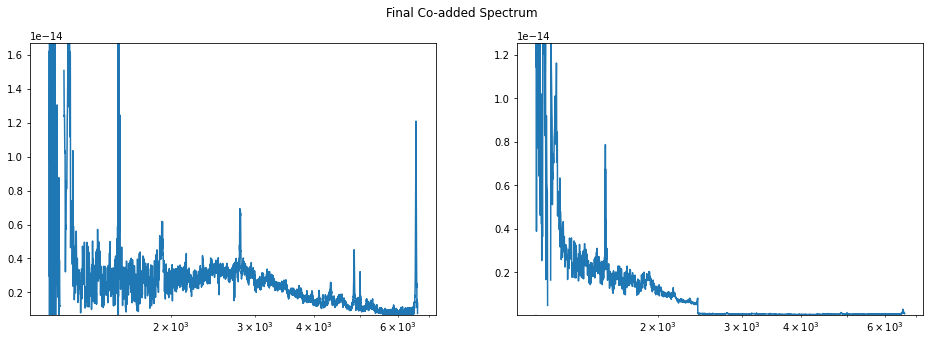

Good: J00392-5117


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 11.261000


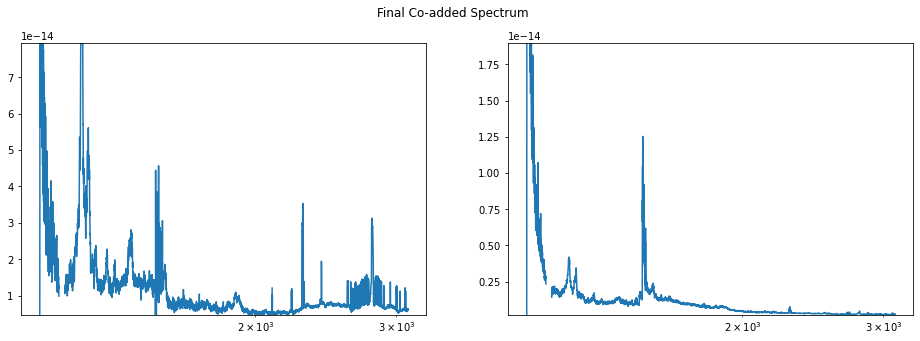

Good: J00535+1241


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 10.430303


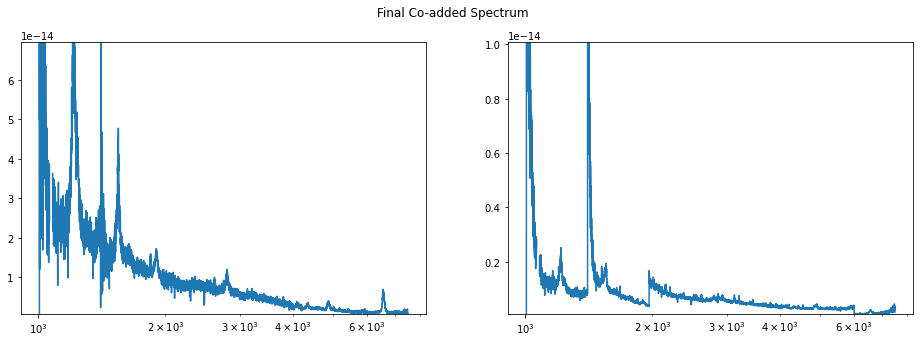

Good: J16279+5522
Median wavelength resolution: 69.09 km/s
Coadd for J21315-1207 is not viable.
SNR is 5.662542


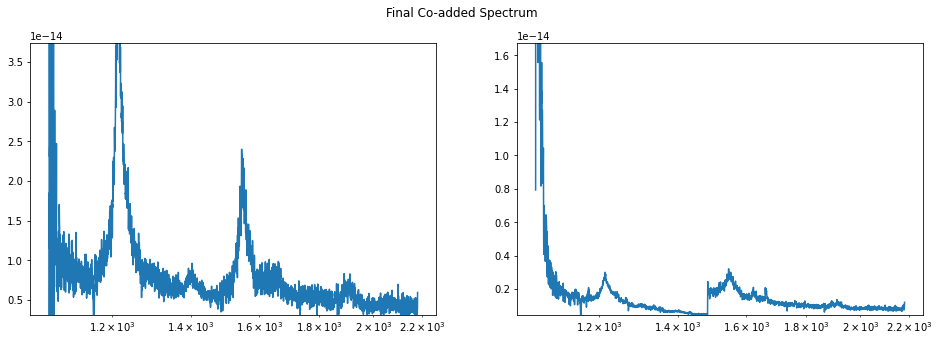

Good: J21315-1207
Median wavelength resolution: 69.09 km/s
SNR is 18.159793


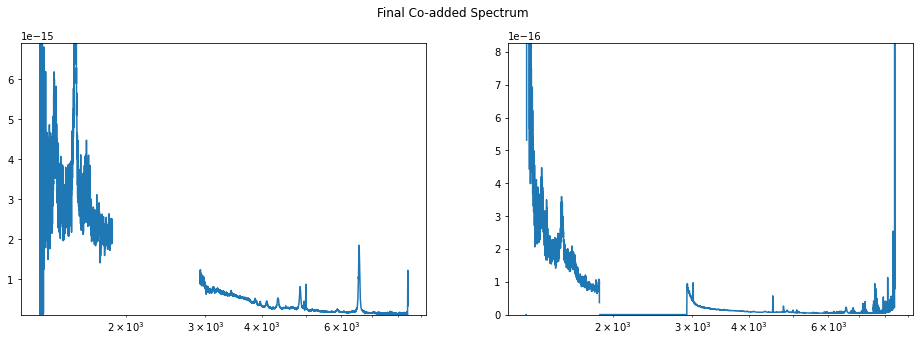

Good: LBQS0003+0146
Median wavelength resolution: 69.09 km/s
Coadd for LBQS0017+0209 is not viable.
SNR is 3.394283


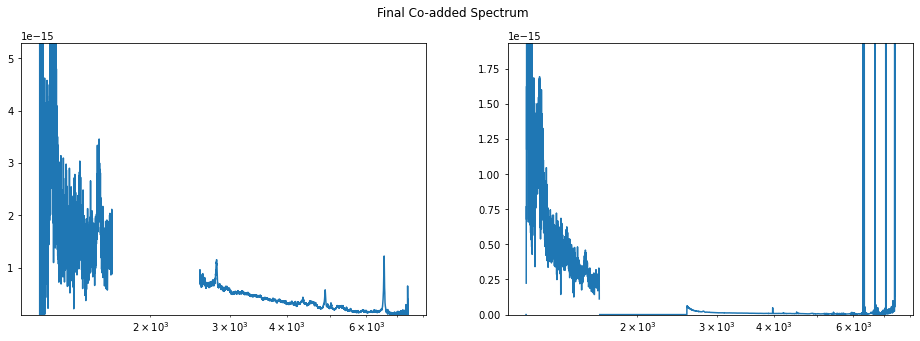

Good: LBQS0017+0209


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 18.604785


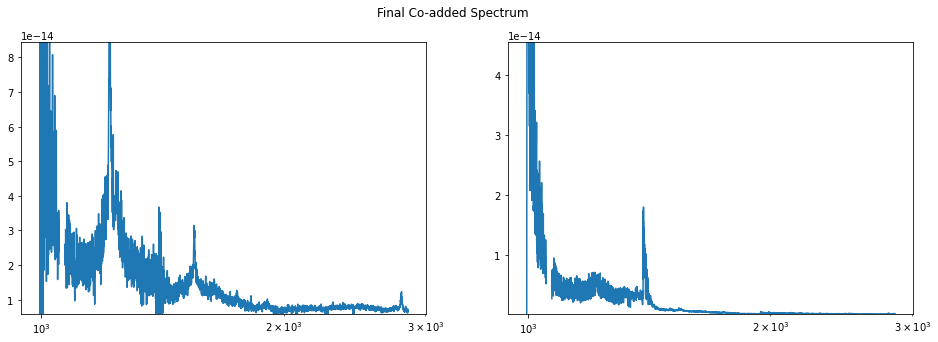

Good: PG0026+129
Median wavelength resolution: 69.09 km/s
Coadd for J00449+1026 is not viable.
SNR is 5.634463


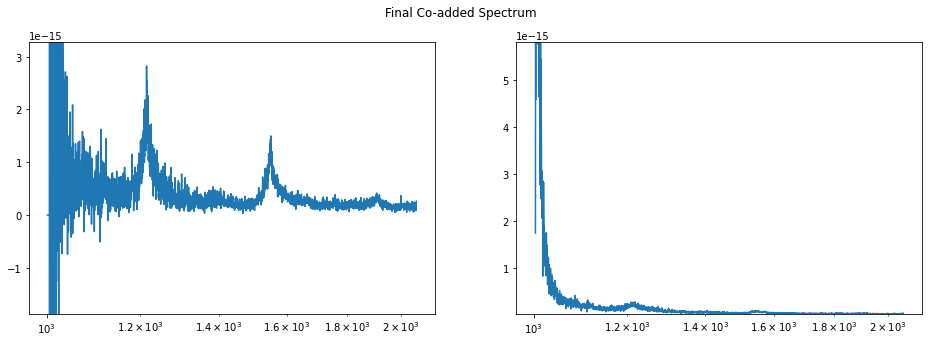

Good: J00449+1026


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for PG0044+030 is not viable.
SNR is 3.551852


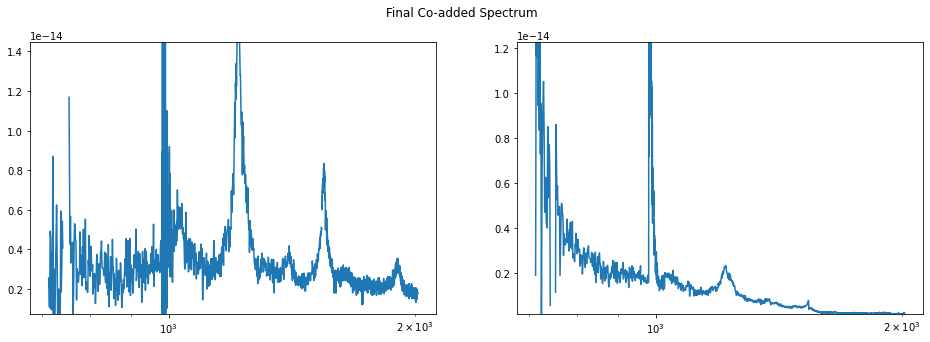

Good: PG0044+030
Median wavelength resolution: 69.09 km/s
SNR is 17.444739


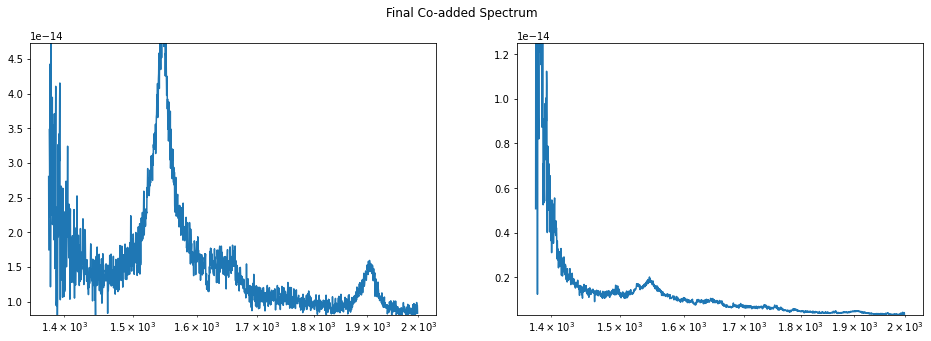

Good: PG0052+251
Median wavelength resolution: 69.09 km/s
Coadd for LBQS0100+0205 is not viable.
SNR is 1.504330


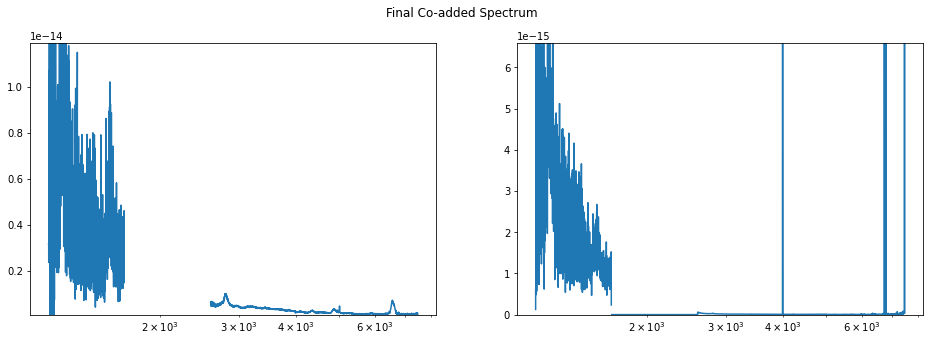

Good: LBQS0100+0205


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 12.592173


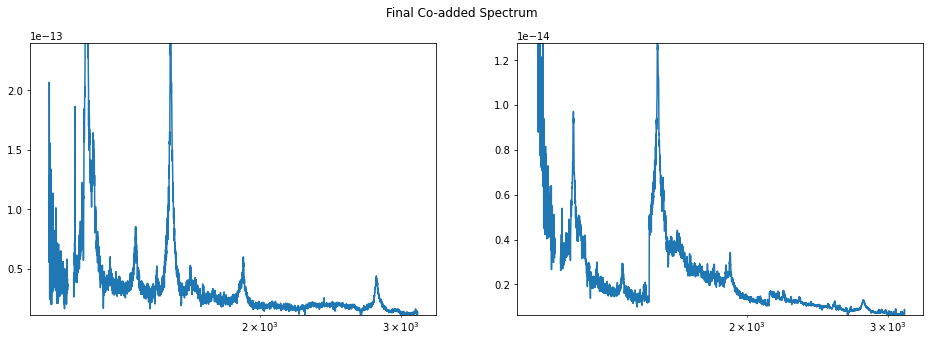

Good: Fairall9


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 38.487551


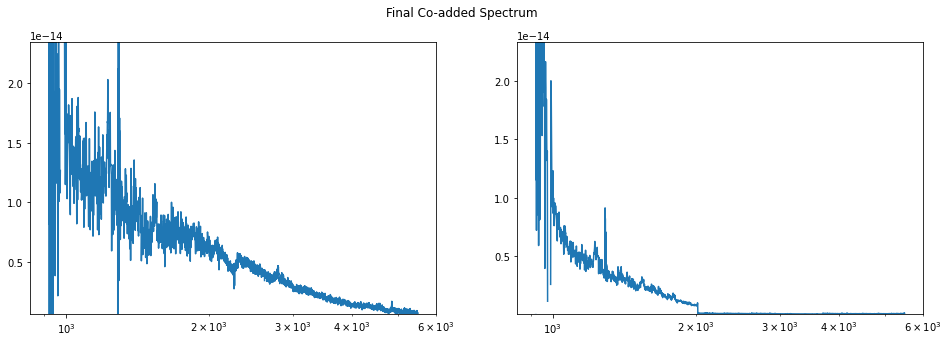

Good: HE0132-4313


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for UM355 is not viable.
SNR is 3.509544


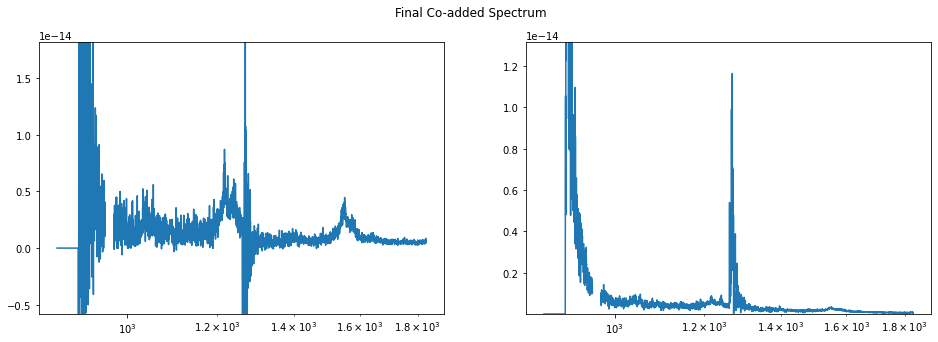

Good: UM355
Median wavelength resolution: 69.09 km/s
SNR is 20.925377


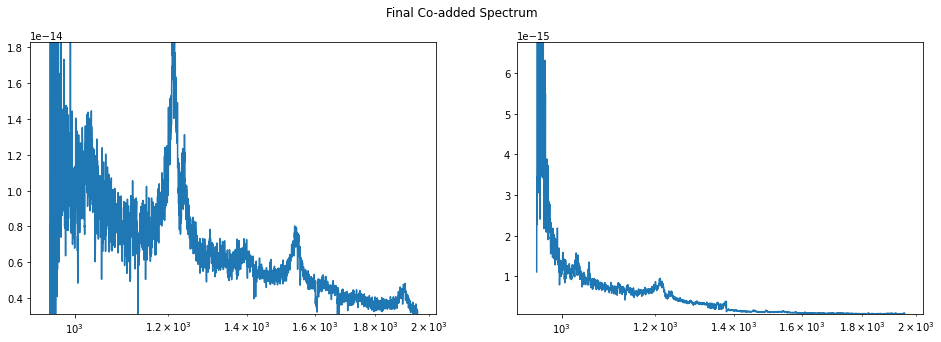

Good: 3C057
Median wavelength resolution: 69.09 km/s
Coadd for J02171+1104 is not viable.
SNR is 5.594191


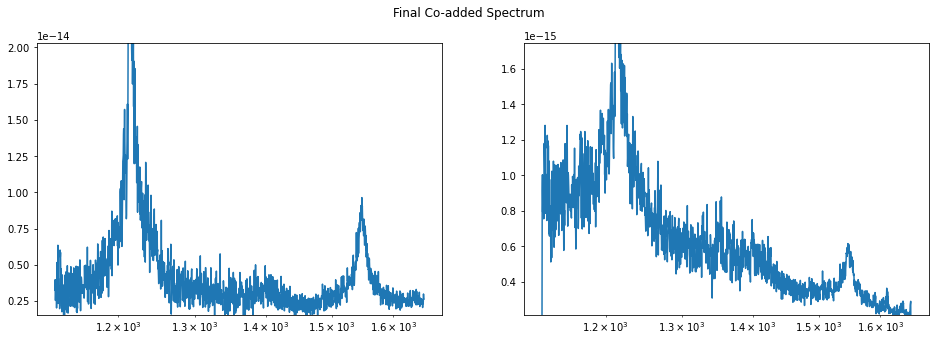

Good: J02171+1104


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for 3C095 is not viable.
SNR is 5.648282


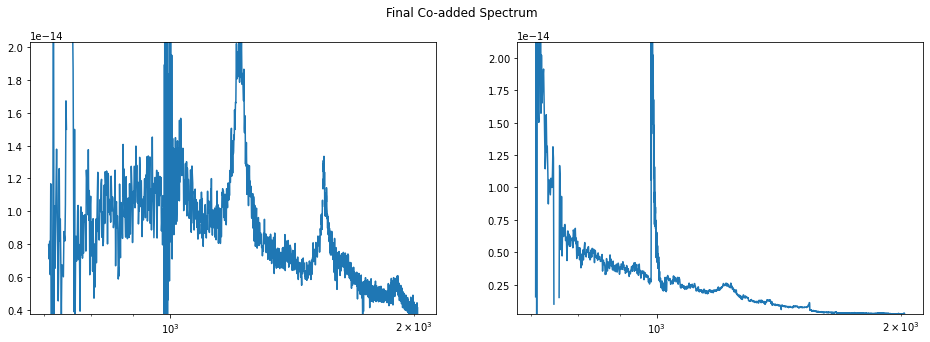

Good: 3C095
Median wavelength resolution: 69.09 km/s
SNR is 14.351729


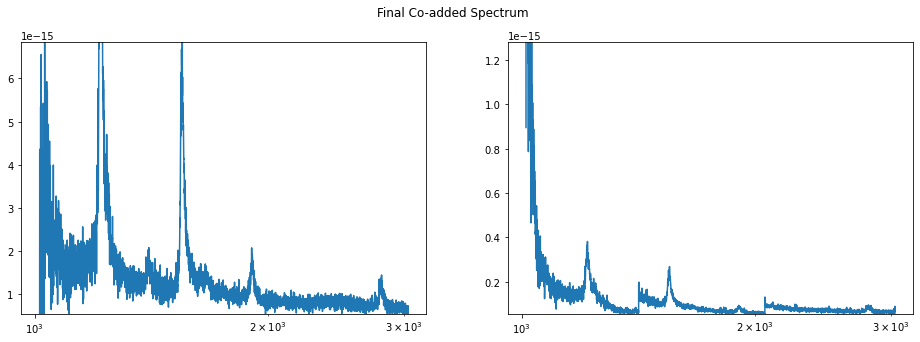

Good: J04055-1308
Median wavelength resolution: 69.09 km/s
SNR is 14.025811


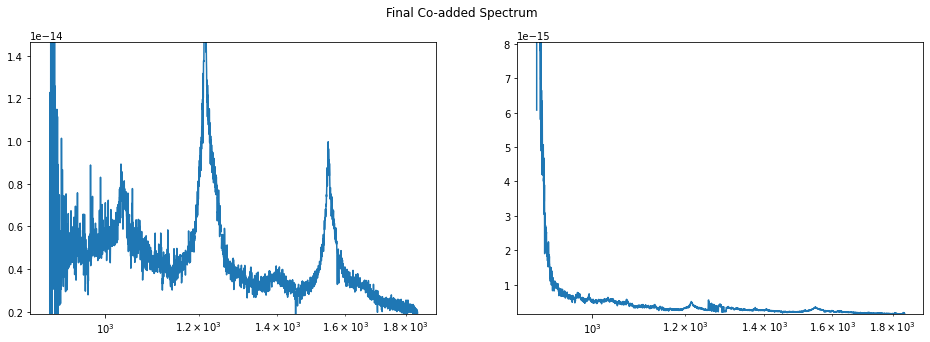

Good: 3C110
Median wavelength resolution: 69.09 km/s
SNR is 21.286877


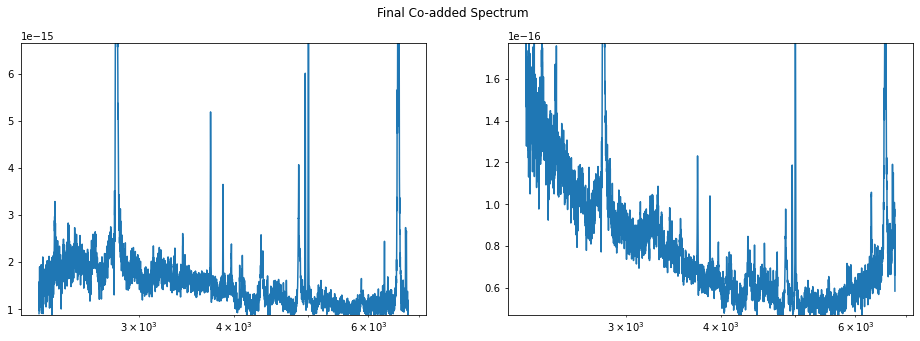

Good: NGC1566
Median wavelength resolution: 69.09 km/s
SNR is 16.994467


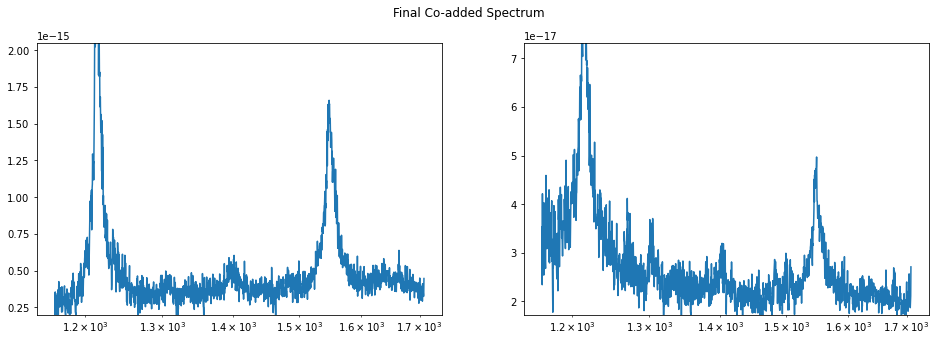

Good: J04232-0120
Median wavelength resolution: 69.09 km/s
SNR is 9.192764


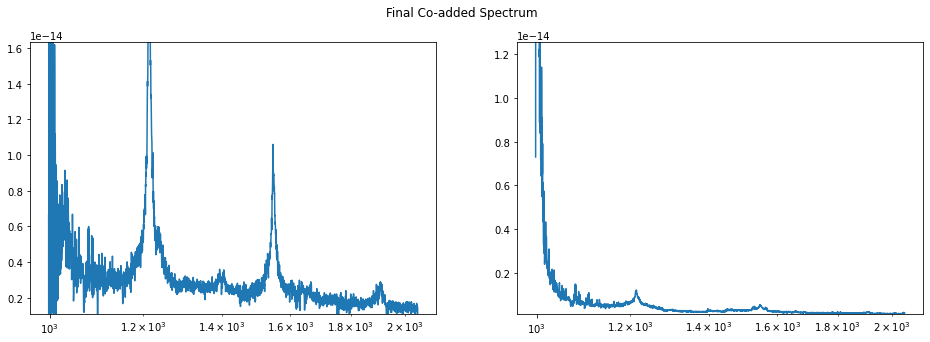

Good: J04412-4313
Median wavelength resolution: 69.09 km/s
SNR is 31.629375


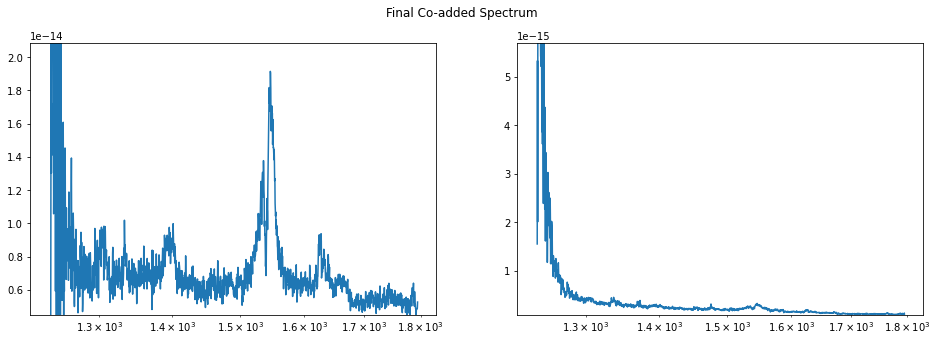

Good: IRAS04505-2958


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Volumes/MyPassportforMac/HST/AllHSTCode/LowerResHSTRebin_TVM.py:99: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_HST_rebin[i] = (m_err*wave_HST_rebin[i] + b_err) * np.sqrt(old_width/new_width)


Median wavelength resolution: 69.09 km/s
Coadd for J04561-2159 is not viable.
SNR is 6.529343


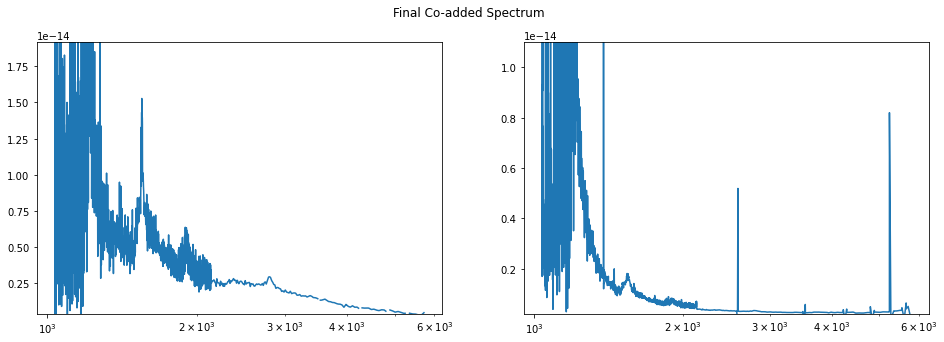

Good: J04561-2159


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 10.637623


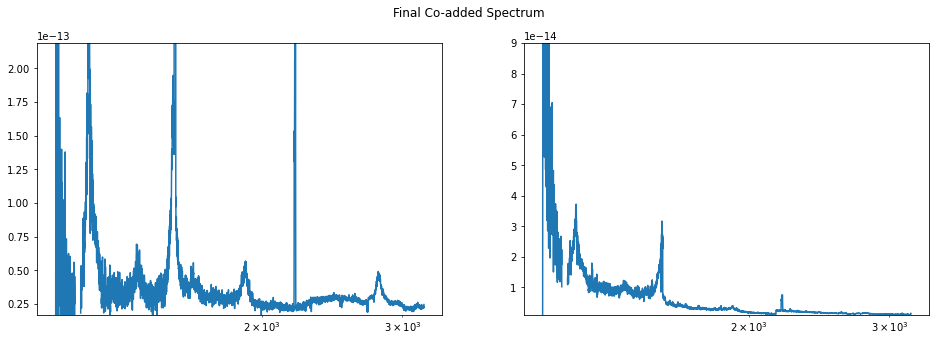

Good: Ark120


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J05198-4546 is not viable.
SNR is 1.866269


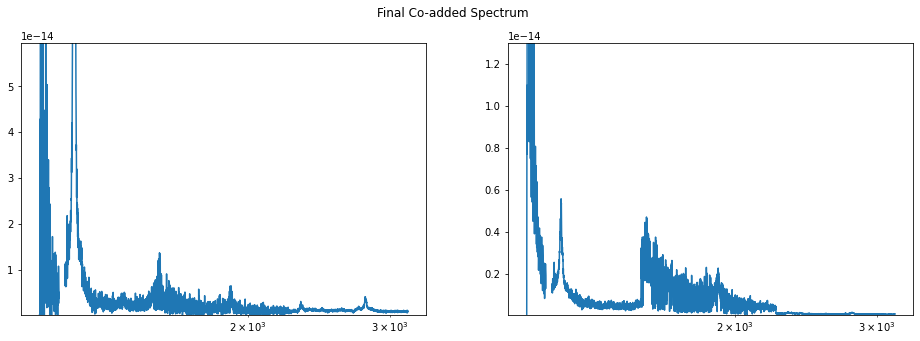

Good: J05198-4546
Median wavelength resolution: 69.09 km/s
SNR is 12.195886


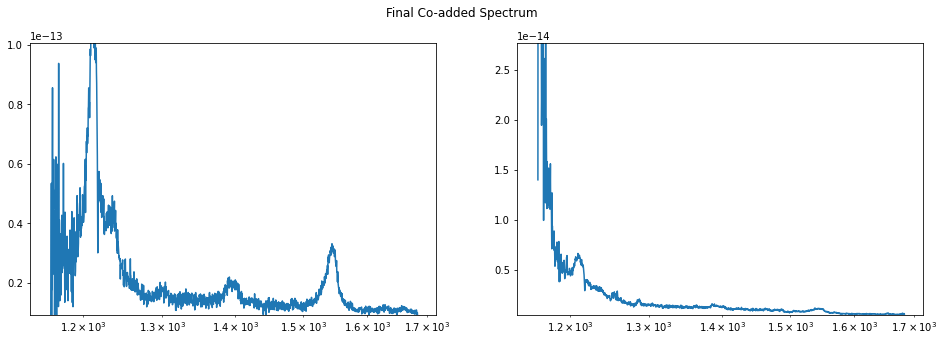

Good: HS 0624+6907
BAD!: J06357-7516


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for FBQS J074541.6+314256 is not viable.
SNR is 3.749339


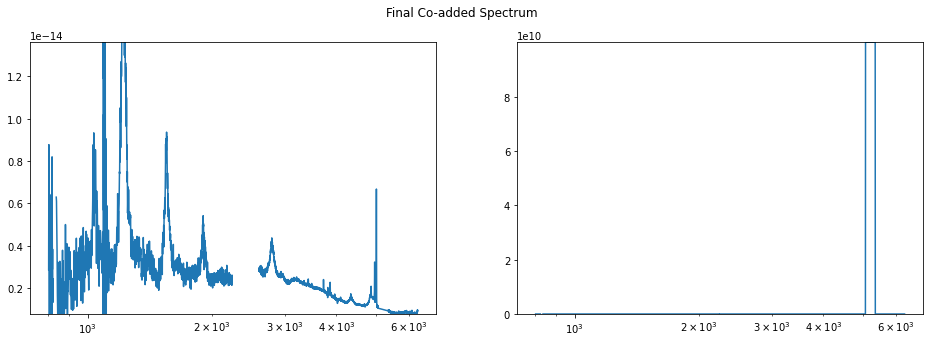

Good: FBQS J074541.6+314256
Median wavelength resolution: 69.09 km/s
SNR is 10.991187


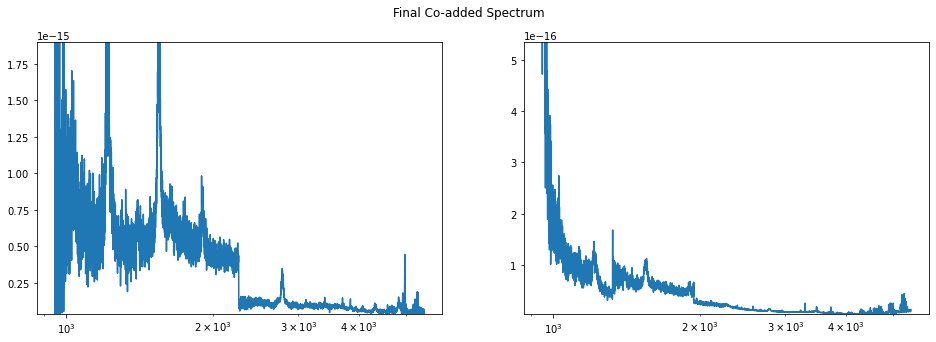

Good: 3C207


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J08535+4349 is not viable.
SNR is 3.177937


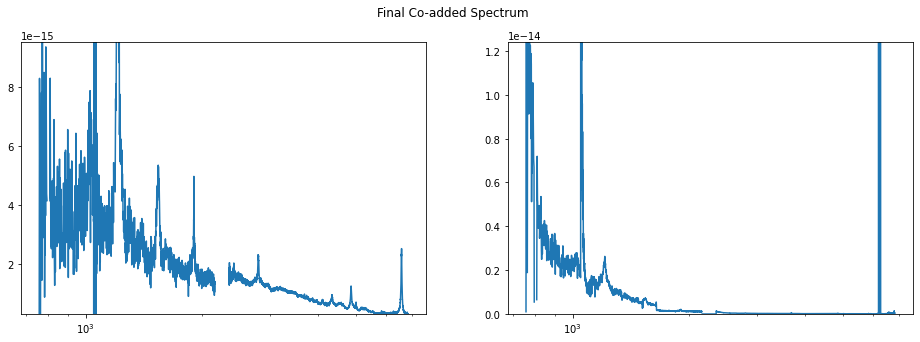

Good: J08535+4349
Median wavelength resolution: 69.09 km/s
SNR is 9.090102


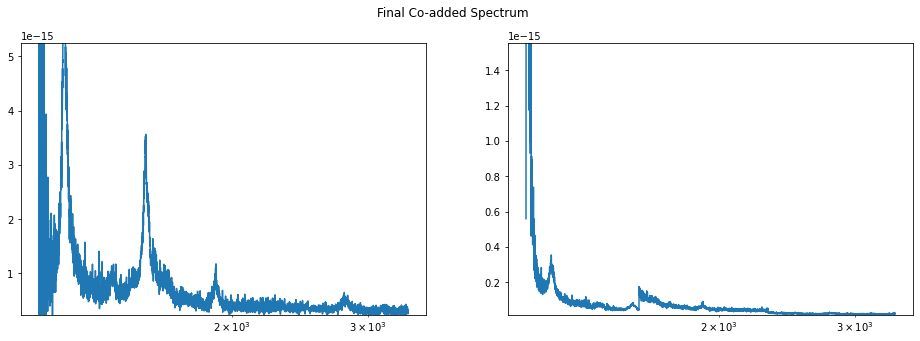

Good: 3C215


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for NGC2841 is not viable.
SNR is 4.323347


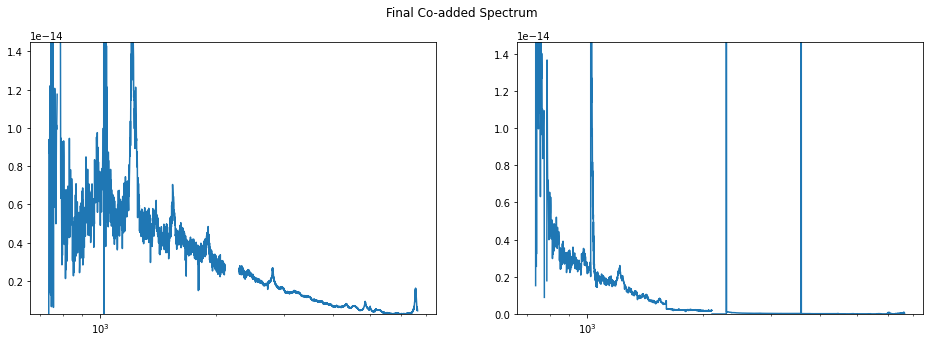

Good: NGC2841
Median wavelength resolution: 69.09 km/s
SNR is 38.760737


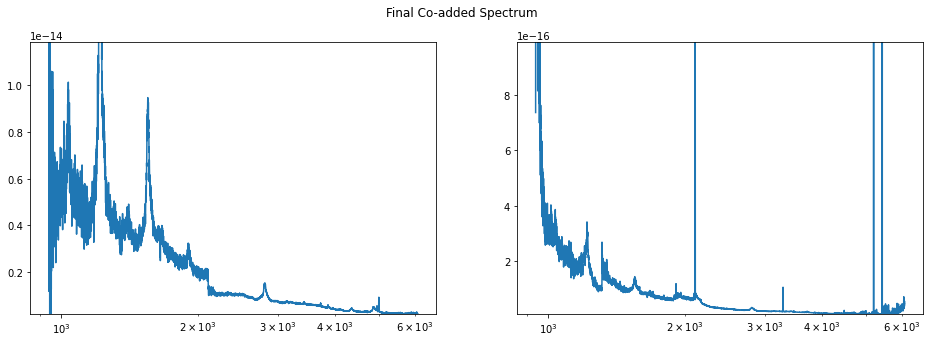

Good: J09270+3902


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 14.403725


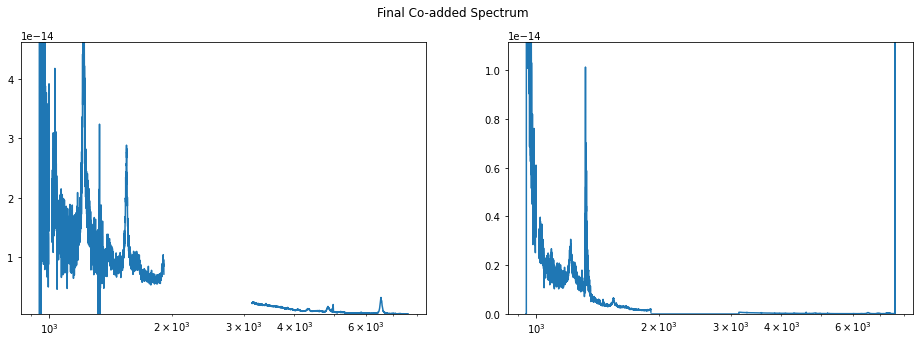

Good: PG0947+396


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for 3C232 is not viable.
SNR is 4.154869


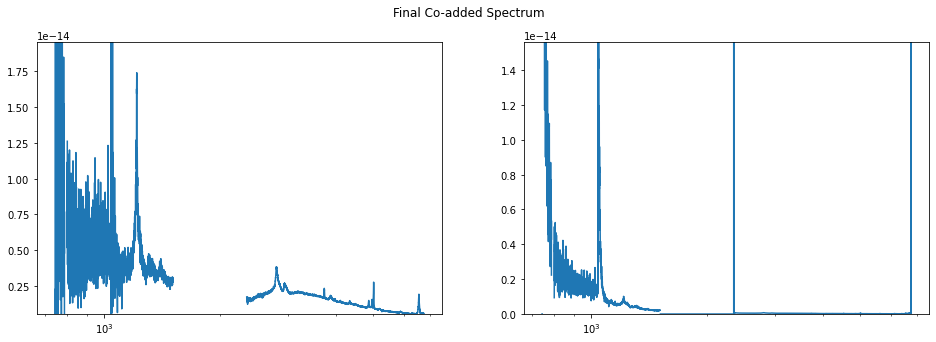

Good: 3C232


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for PG1001+054 is not viable.
SNR is 6.248229


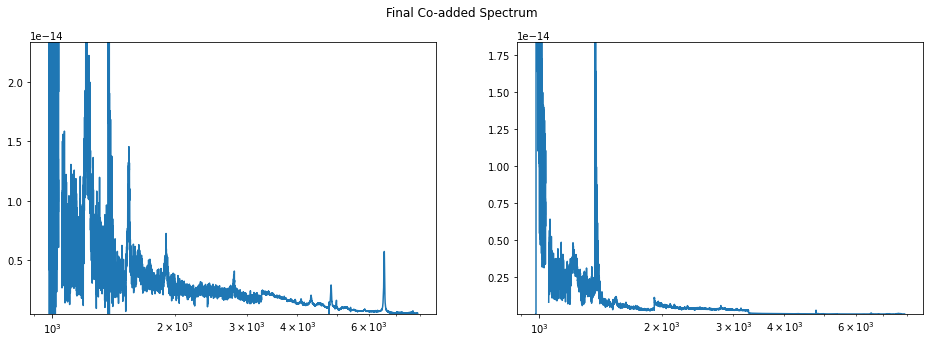

Good: PG1001+054


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J10104+4132 is not viable.
SNR is 4.892986


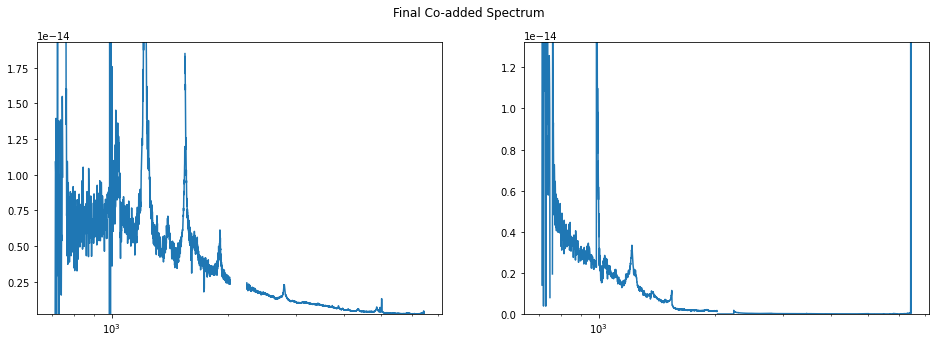

Good: J10104+4132
Median wavelength resolution: 69.09 km/s
SNR is 33.708070


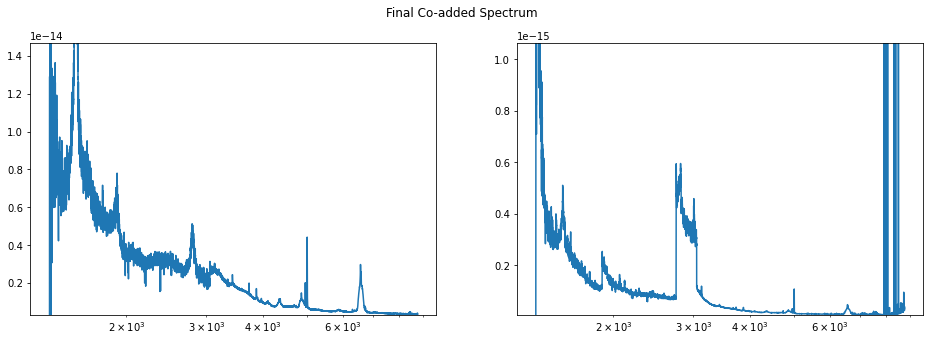

Good: J10309+3102
Median wavelength resolution: 69.09 km/s
SNR is 8.175082


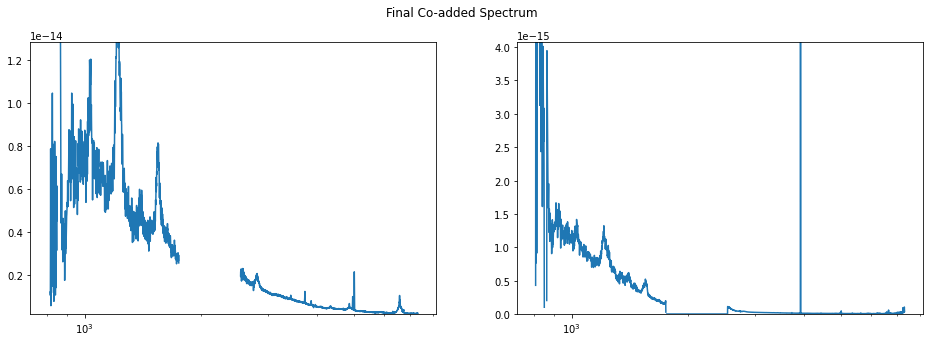

Good: J10525+6125


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for PG1100+772 is not viable.
SNR is 5.648443


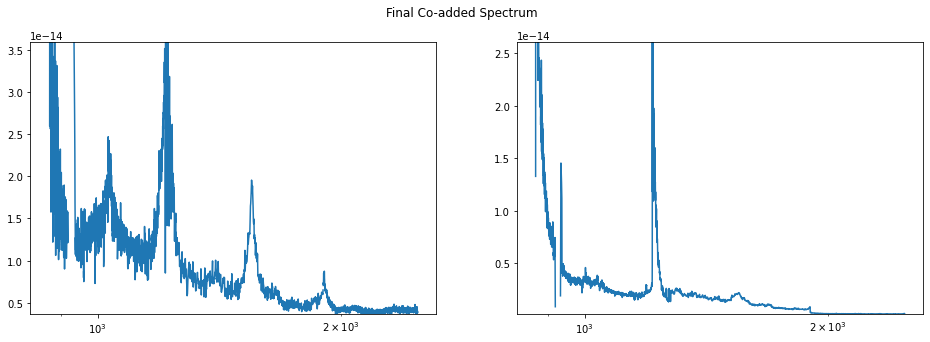

Good: PG1100+772


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J11072+1628 is not viable.
SNR is 5.325065


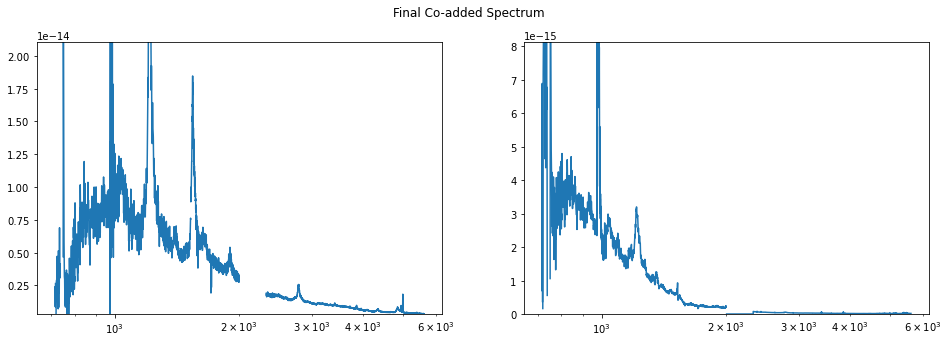

Good: J11072+1628
Median wavelength resolution: 69.09 km/s
SNR is 18.000735


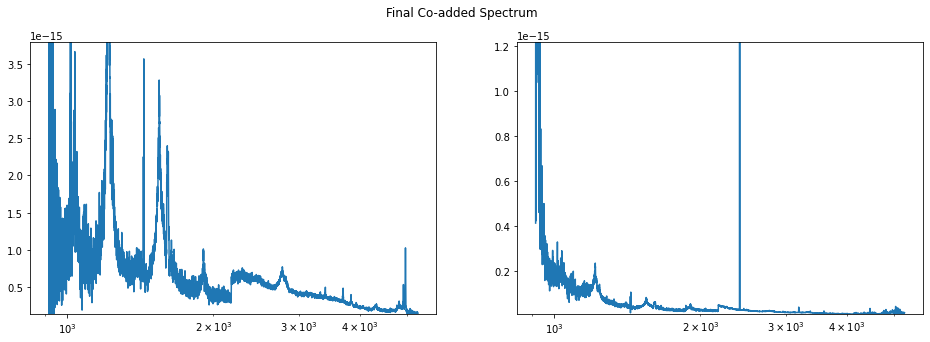

Good: 3C254
Median wavelength resolution: 69.09 km/s
SNR is 30.596705


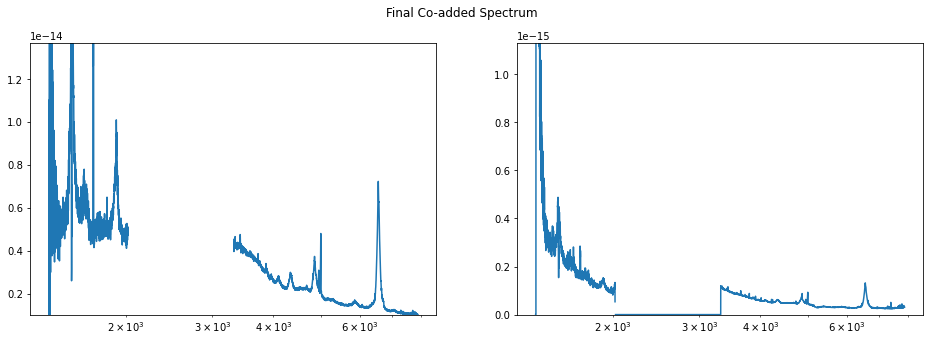

Good: PG1114+445


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 10.542589


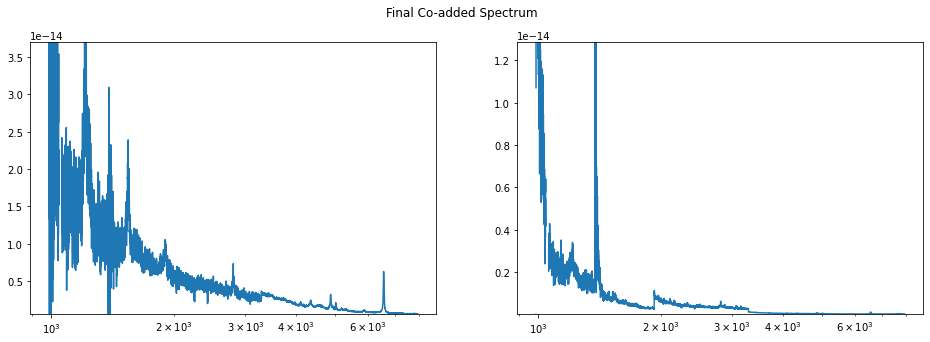

Good: PG1115+407


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 12.815876


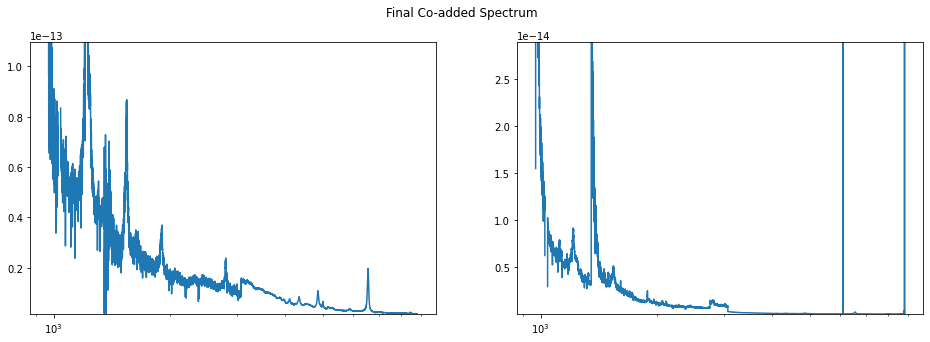

Good: PG1116+215
Median wavelength resolution: 69.09 km/s
Coadd for LBQS1132-0302 is not viable.
SNR is 6.038003


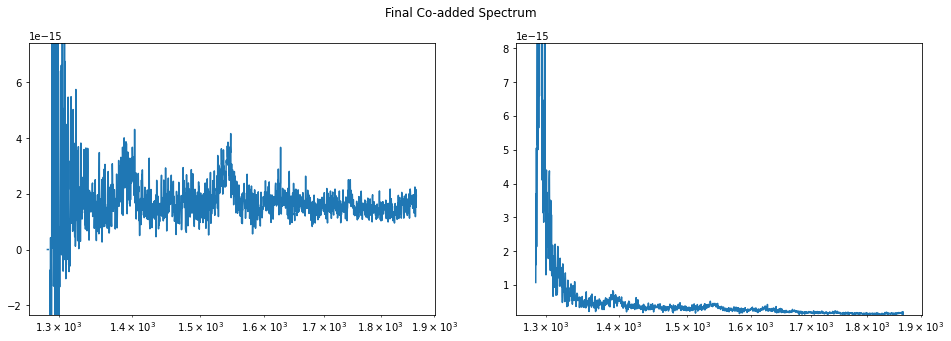

Good: LBQS1132-0302


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J11391-1350 is not viable.
SNR is 3.640063


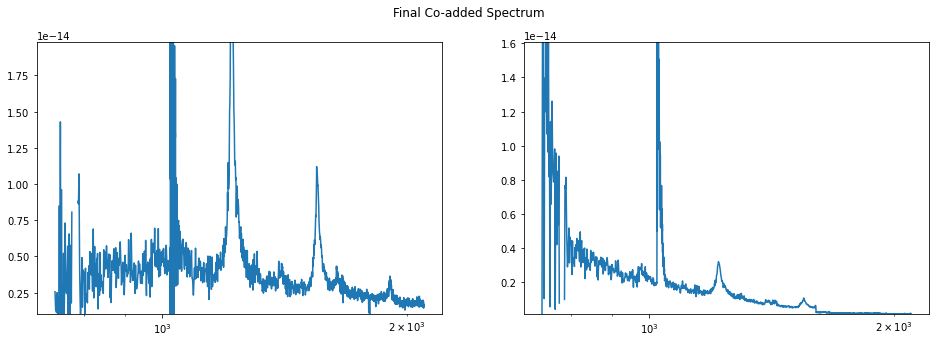

Good: J11391-1350
Median wavelength resolution: 69.09 km/s
SNR is 7.925925


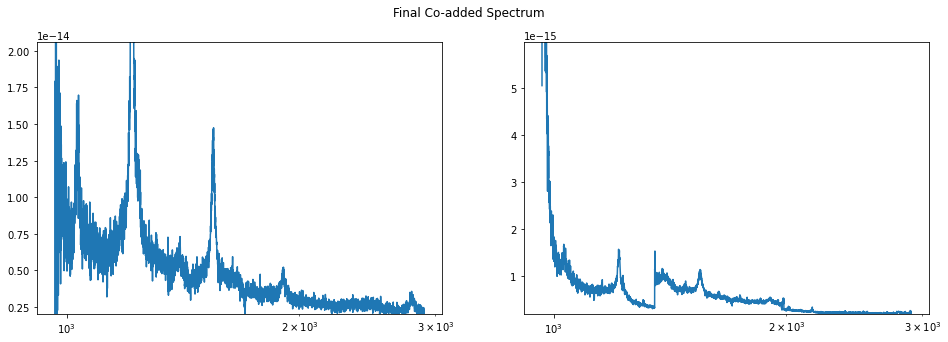

Good: 3C263
Median wavelength resolution: 69.09 km/s
Coadd for LBQS1138+0204 is not viable.
SNR is 6.674977


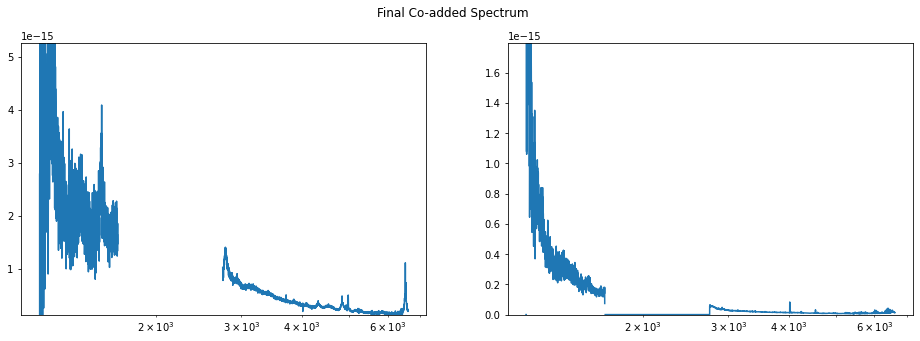

Good: LBQS1138+0204
Median wavelength resolution: 69.09 km/s
Coadd for LBQS1144-0115 is not viable.
SNR is 4.672872


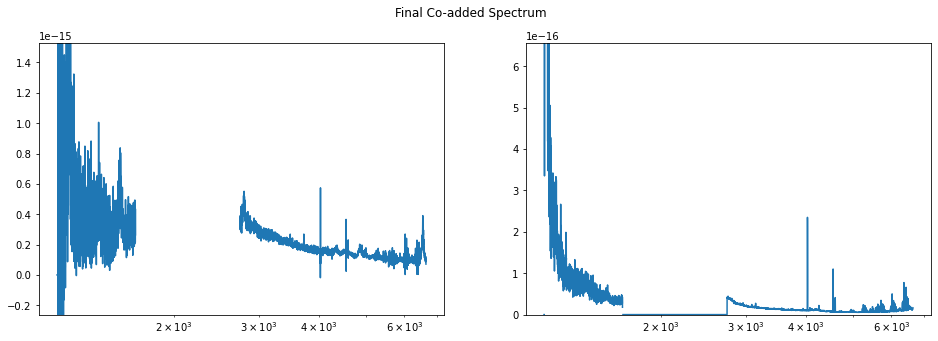

Good: LBQS1144-0115
Median wavelength resolution: 69.09 km/s
Coadd for SBS1150+497 is not viable.
SNR is 3.425707


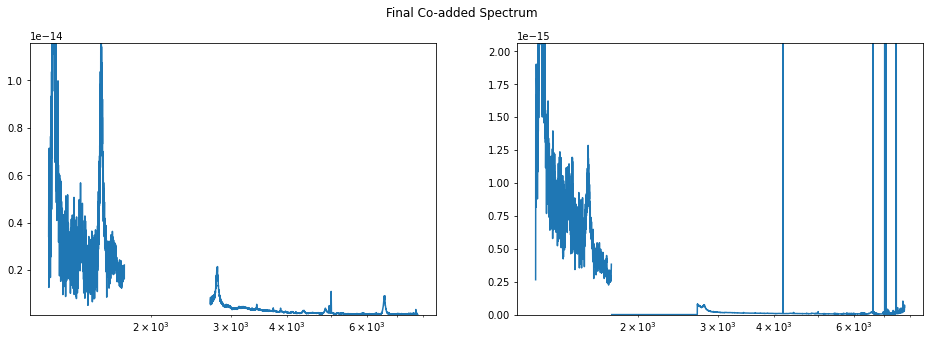

Good: SBS1150+497
Median wavelength resolution: 69.09 km/s
SNR is 19.639257


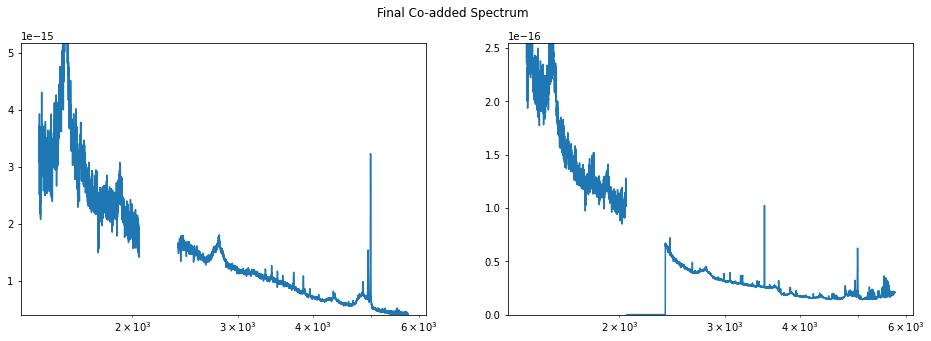

Good: J11586+6254
Median wavelength resolution: 69.09 km/s
SNR is 11.341554


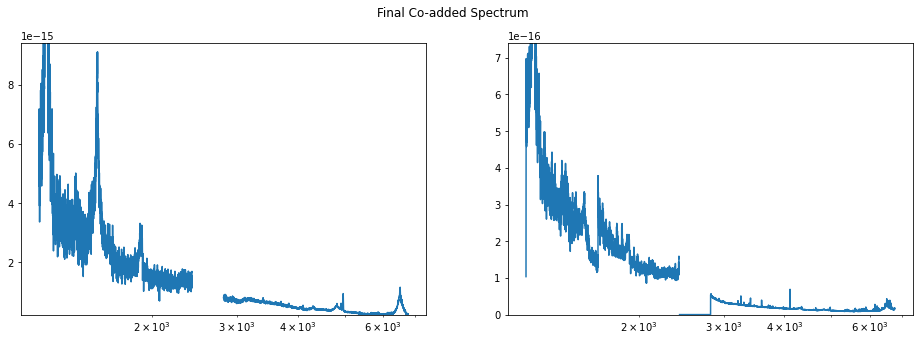

Good: J11594+2106
Median wavelength resolution: 69.09 km/s
Coadd for J12047+2754 is not viable.
SNR is 6.873411


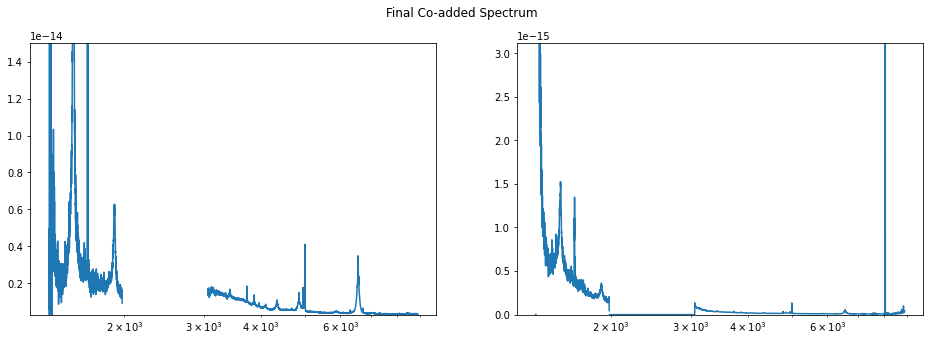

Good: J12047+2754


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for PG1211+143 is not viable.
SNR is 5.707207


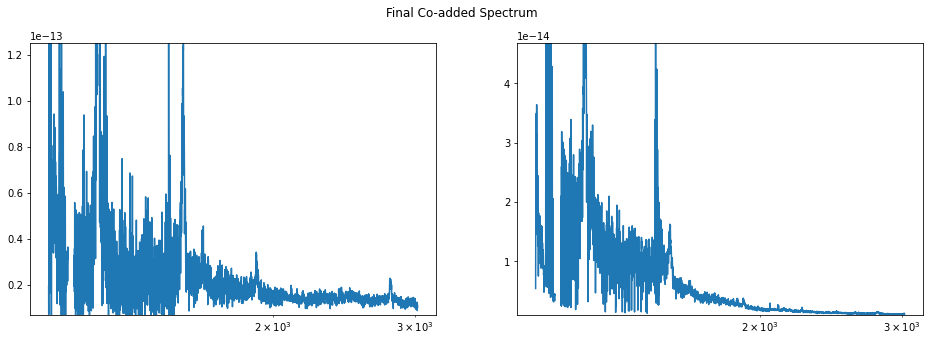

Good: PG1211+143
BAD!: 3C273
Median wavelength resolution: 69.09 km/s
SNR is 11.372637


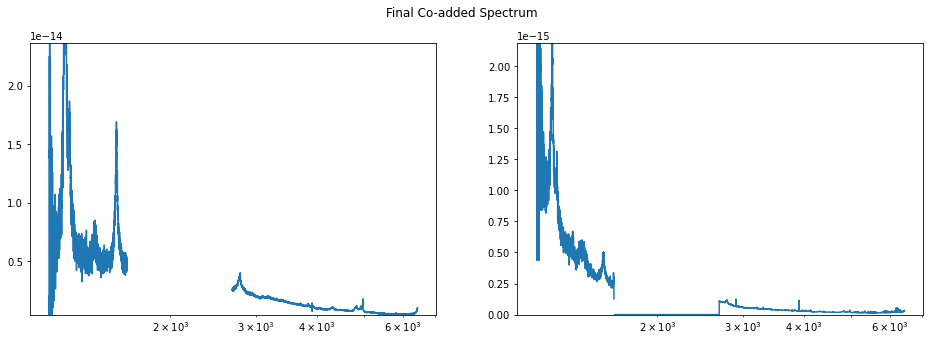

Good: LBQS1230+0947
Median wavelength resolution: 69.09 km/s
SNR is 19.342719


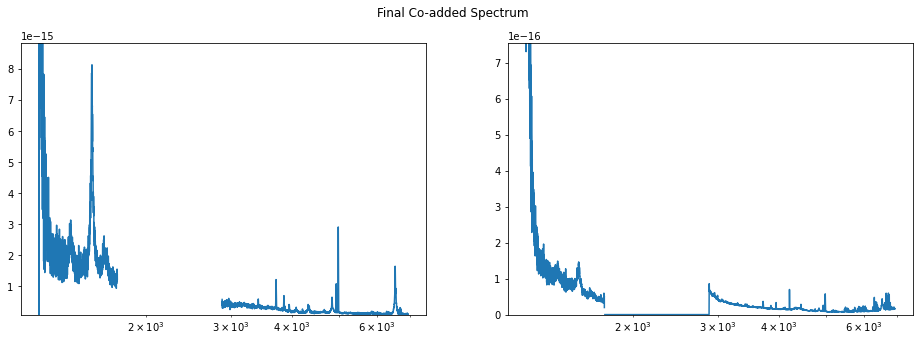

Good: SBS1250+568


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J12546+1141 is not viable.
SNR is 4.889079


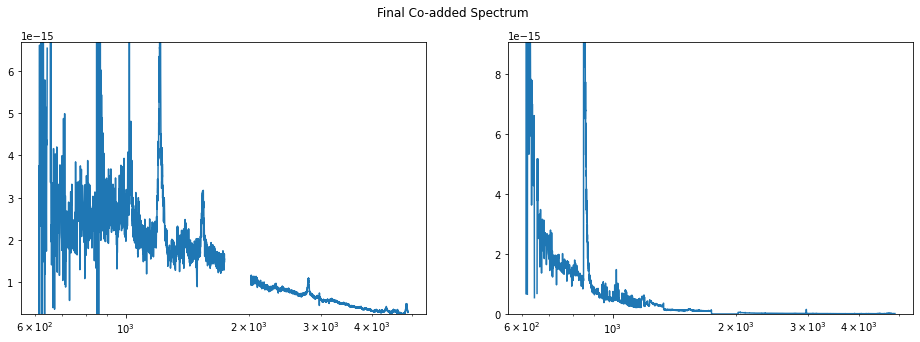

Good: J12546+1141


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 19.722415


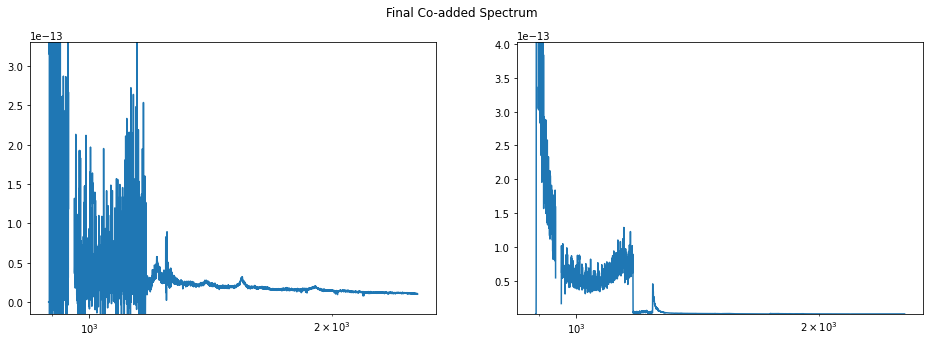

Good: PG1302-102
Median wavelength resolution: 69.09 km/s
SNR is 13.221073


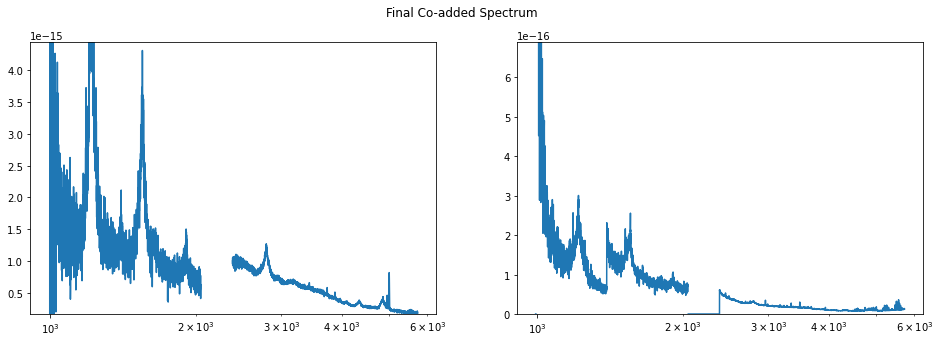

Good: 3C281
Median wavelength resolution: 69.09 km/s
SNR is 11.530073


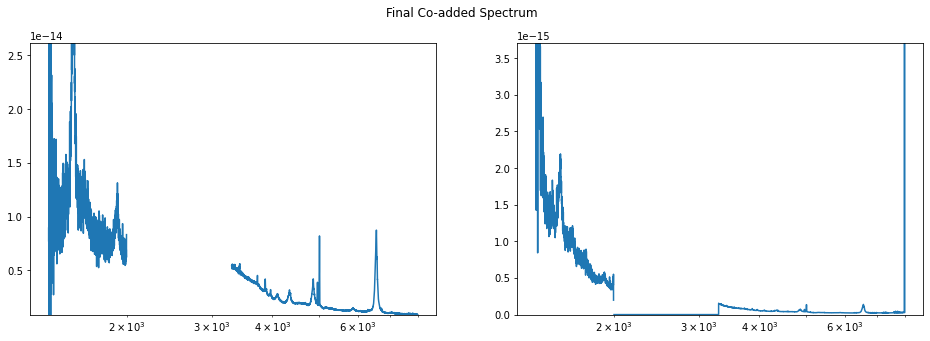

Good: PG1307+085
Median wavelength resolution: 69.09 km/s
SNR is 12.772457


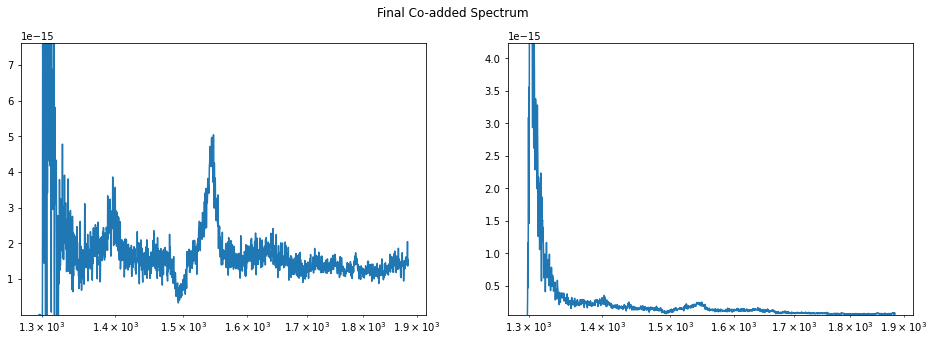

Good: LBQS1317-0142


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 12.369873


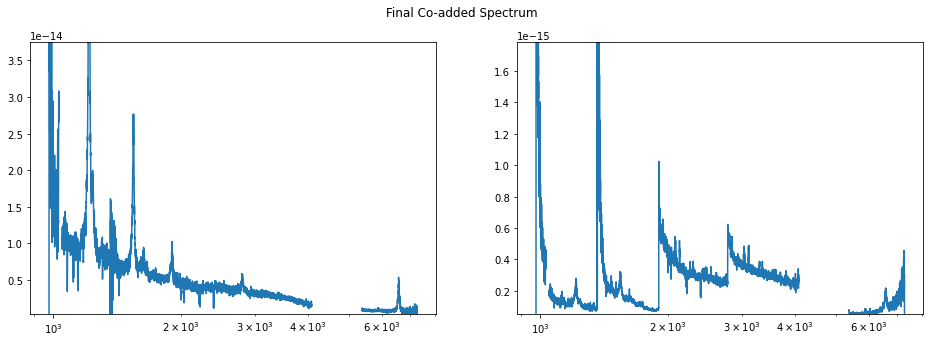

Good: PG1322+659


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 11.712095


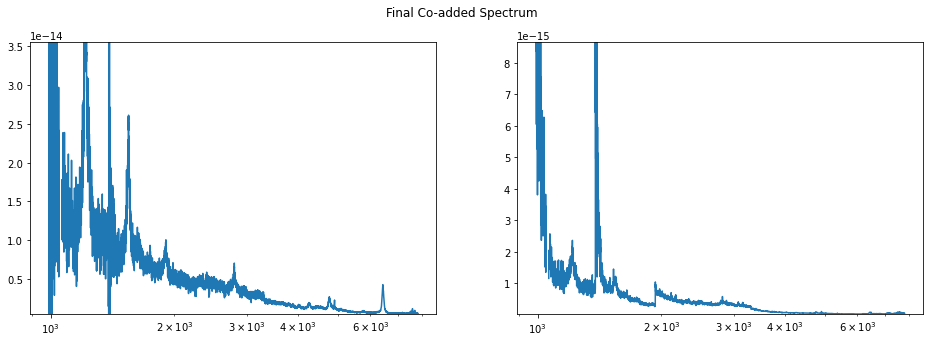

Good: PG1352+183


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J13570+1919 is not viable.
SNR is 3.258035


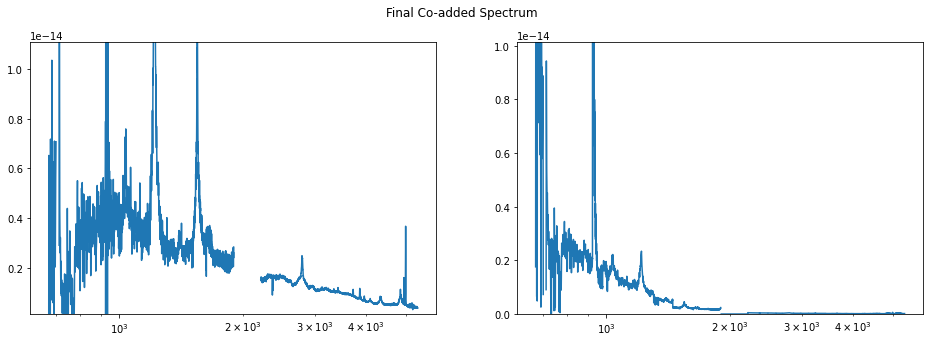

Good: J13570+1919
Median wavelength resolution: 69.09 km/s
SNR is 14.065148


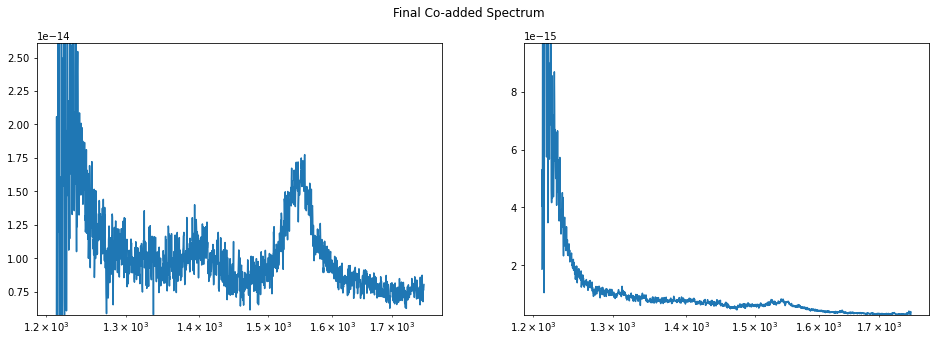

Good: J13590-4152


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 9.564391


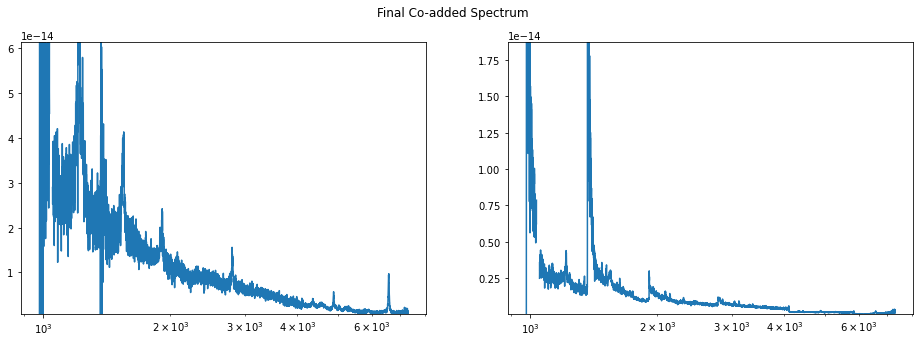

Good: J14052+2555


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 7.332725


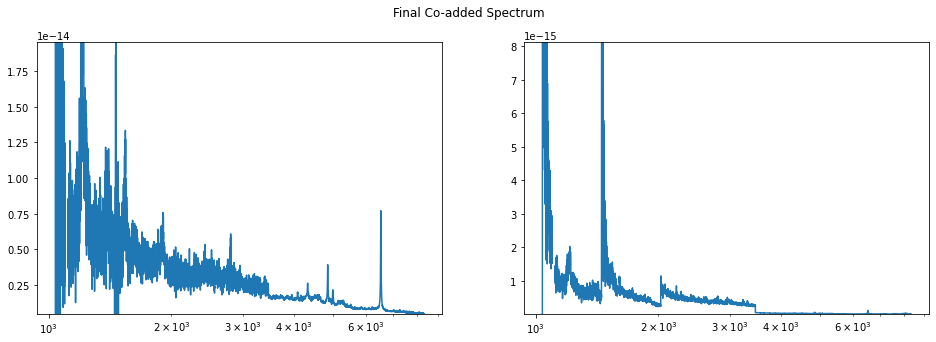

Good: PG1404+226


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 23.224814


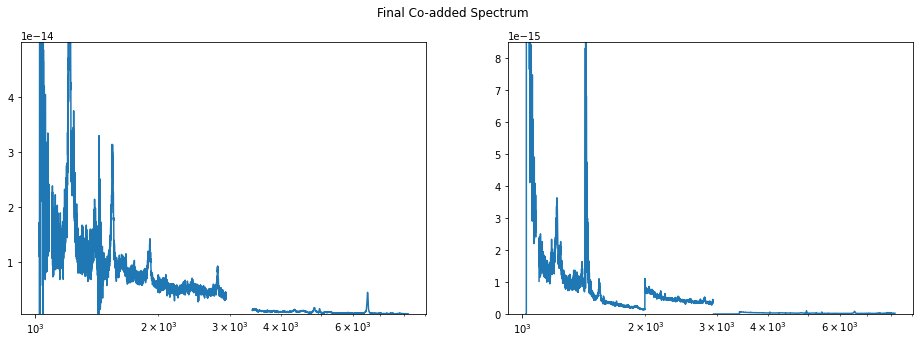

Good: PG1415+451
Median wavelength resolution: 69.09 km/s
Coadd for J14190-1310 is not viable.
SNR is 3.409757


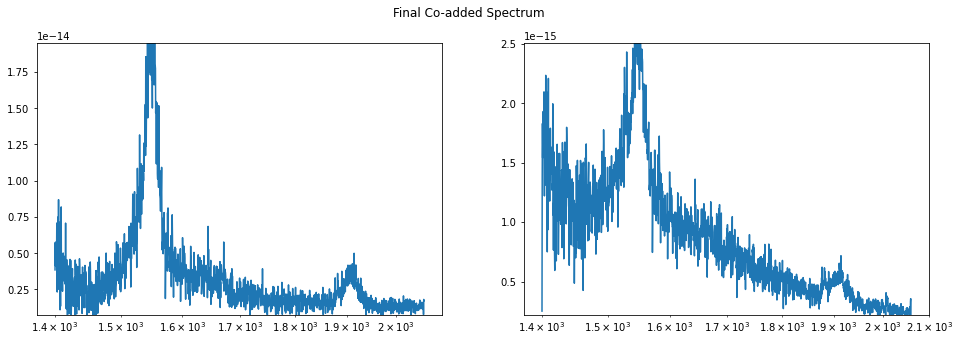

Good: J14190-1310
Median wavelength resolution: 69.09 km/s
SNR is 13.435230


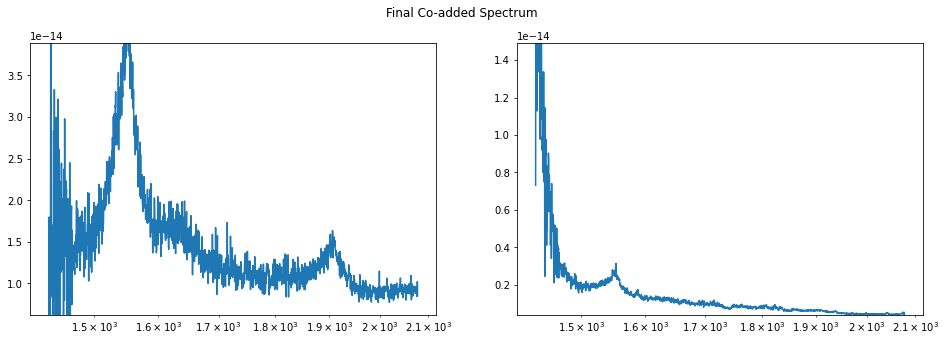

Good: Mrk813
Median wavelength resolution: 69.09 km/s
SNR is 11.901931


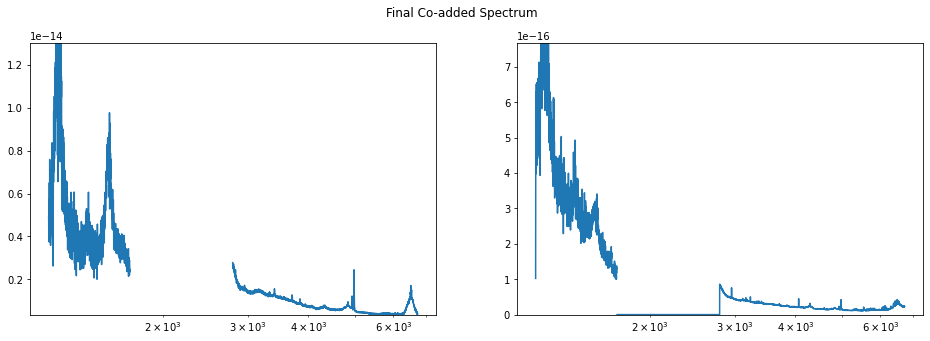

Good: J14275+2632


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 16.727944


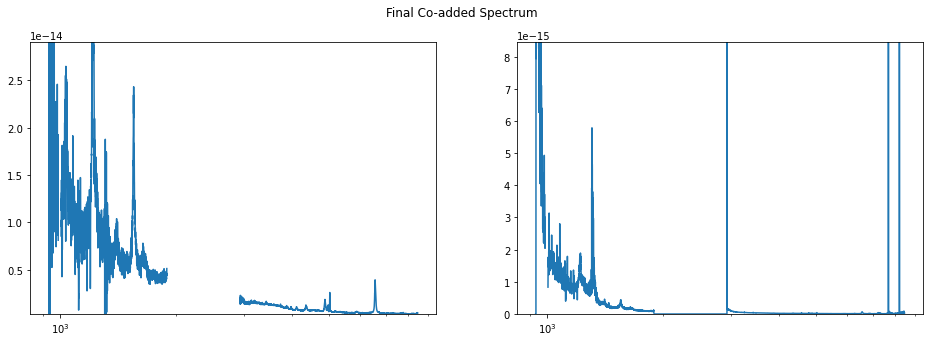

Good: J14297+4747
Median wavelength resolution: 69.09 km/s
SNR is 14.776165


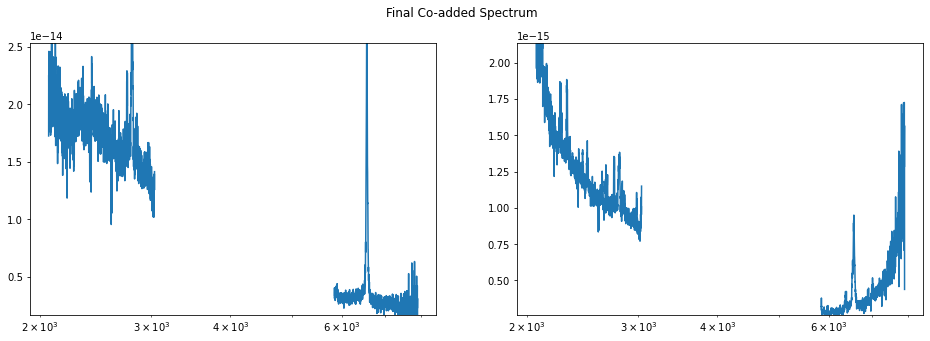

Good: Mrk0478


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J14467+4035 is not viable.
SNR is 4.779951


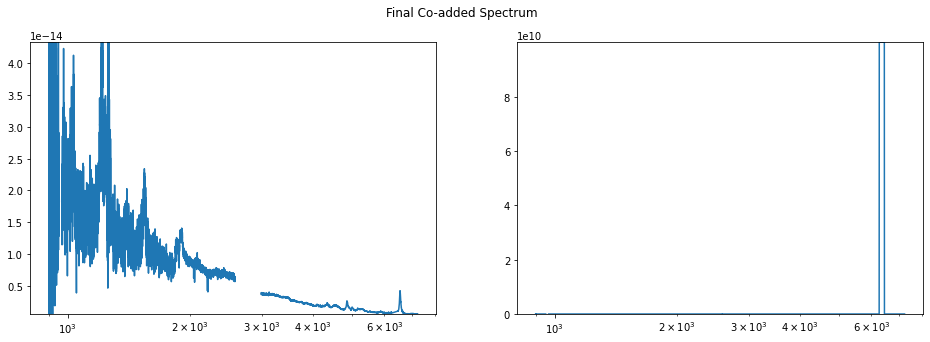

Good: J14467+4035


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J14544-3747 is not viable.
SNR is 2.164503


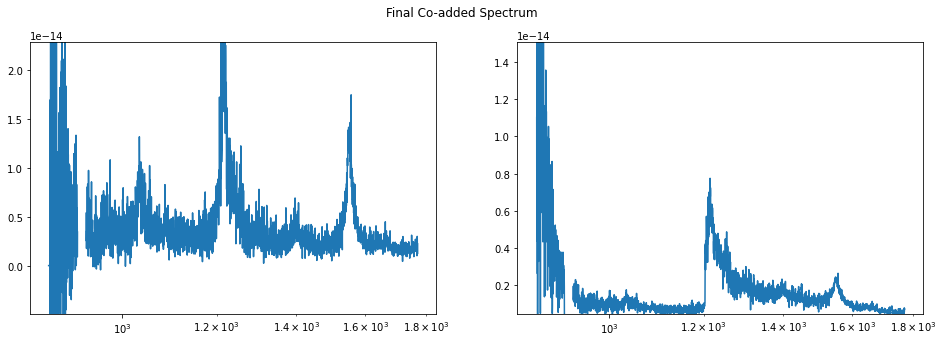

Good: J14544-3747
Median wavelength resolution: 69.09 km/s
SNR is 9.710812


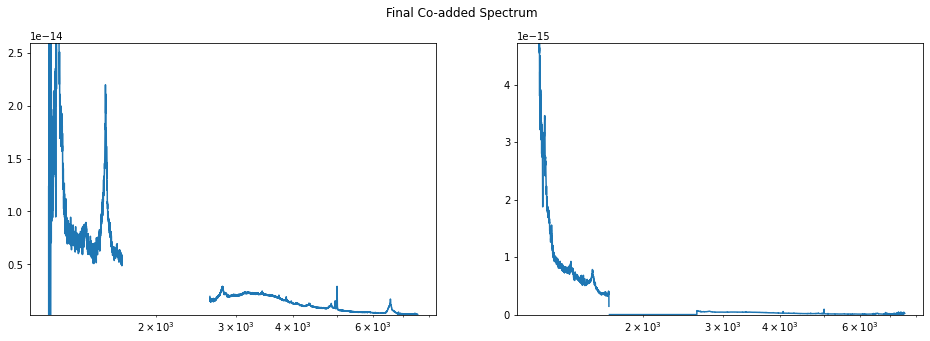

Good: J15147+3650


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J15395+4735 is not viable.
SNR is 3.904779


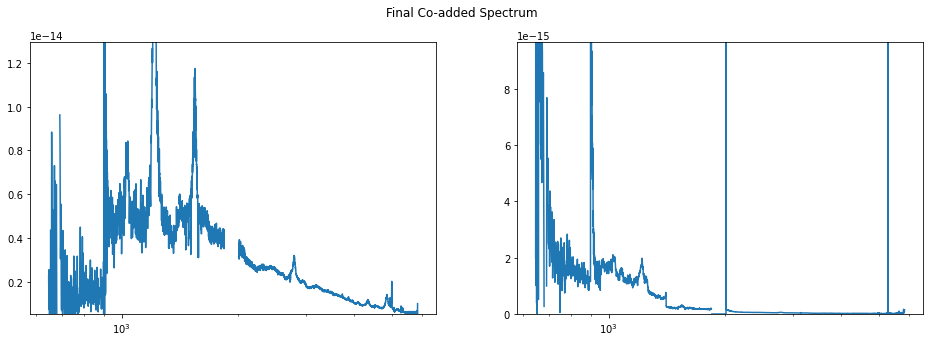

Good: J15395+4735


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 7.237882


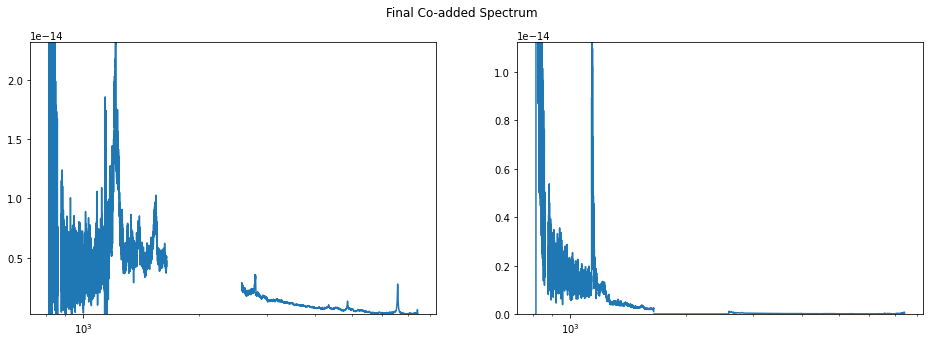

Good: J15455+4846


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for PG1545+210 is not viable.
SNR is 5.416408


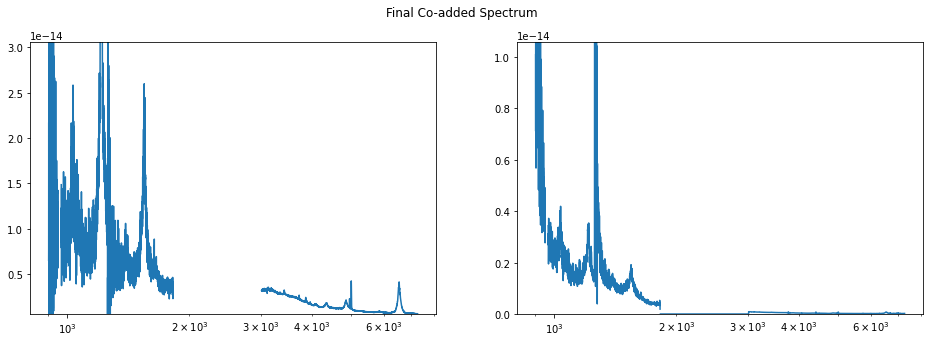

Good: PG1545+210
Median wavelength resolution: 69.09 km/s
SNR is 11.082969


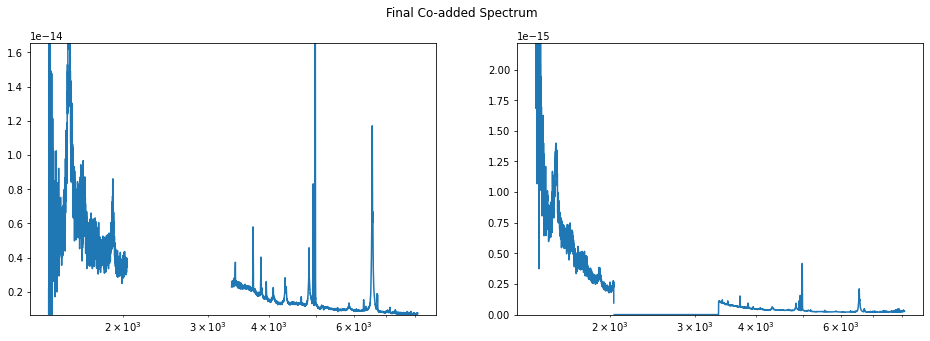

Good: J16142+2604


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for 3C334 is not viable.
SNR is 5.654451


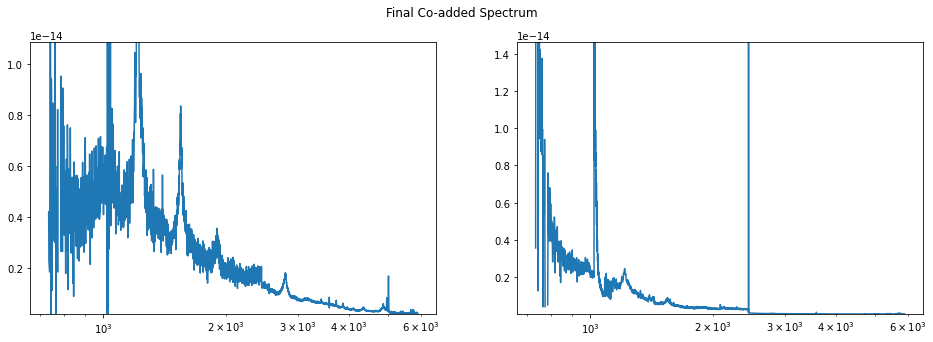

Good: 3C334
Median wavelength resolution: 69.09 km/s
SNR is 14.060582


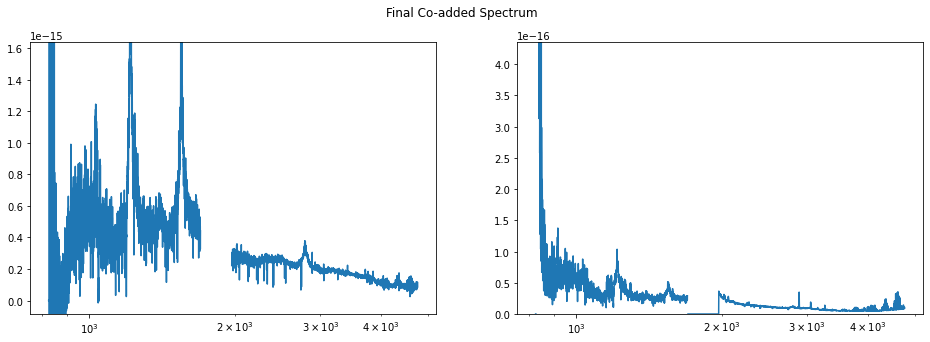

Good: 3C336


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J16303+3756 is not viable.
SNR is 1.137913


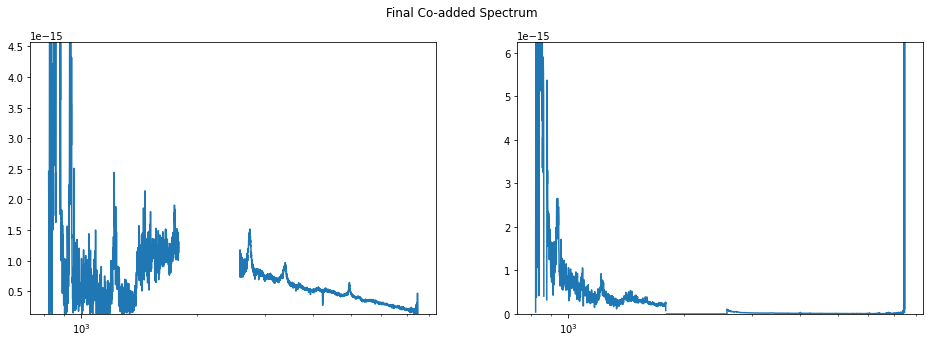

Good: J16303+3756
Median wavelength resolution: 69.09 km/s
Coadd for 3C345 is not viable.
SNR is 6.051277


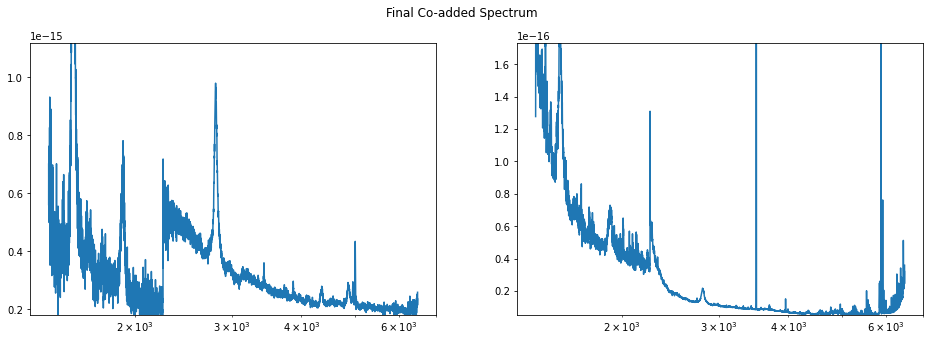

Good: 3C345


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 12.218523


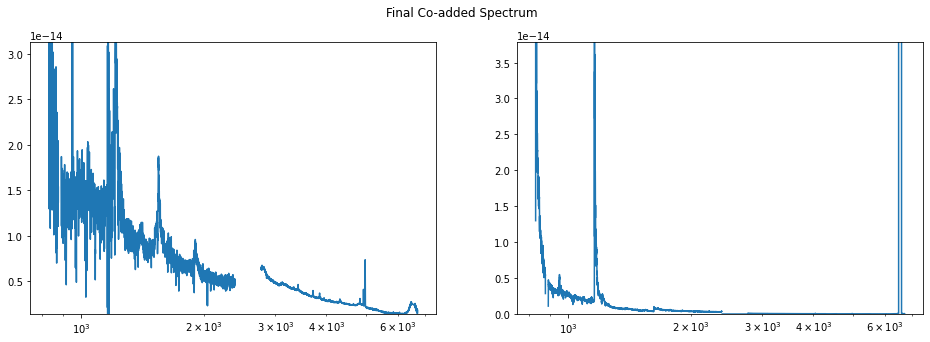

Good: SBS1704+608
BAD!: J18219+6420


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 11.000418


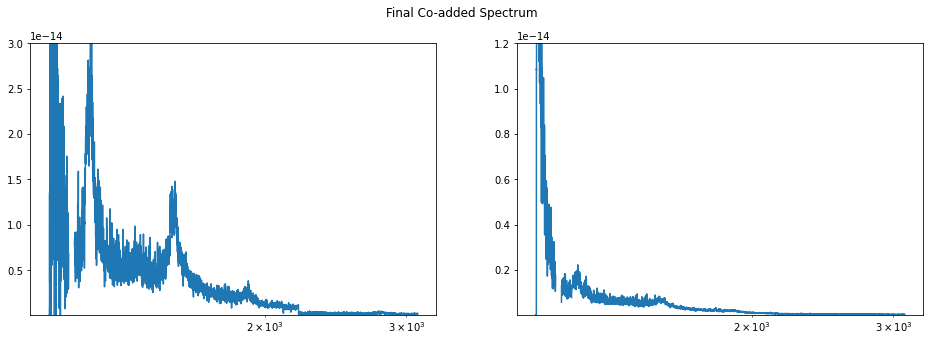

Good: 3C390


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 9.117390


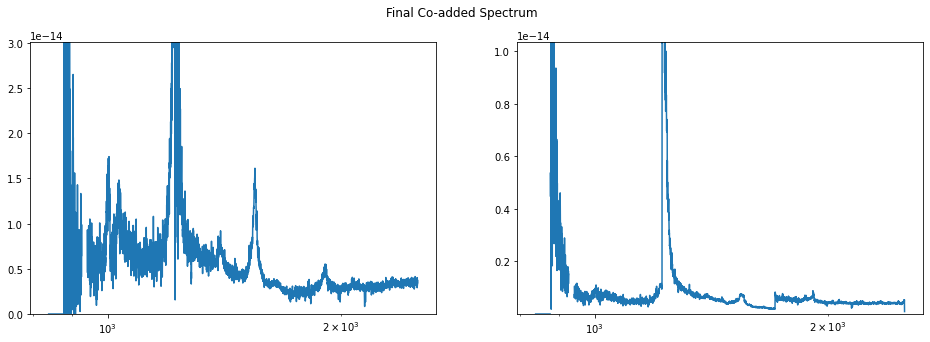

Good: J19278+7358
Median wavelength resolution: 69.09 km/s
SNR is 13.705308


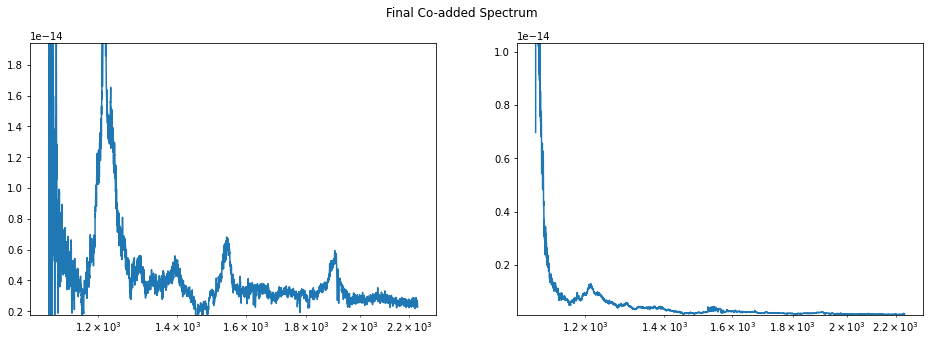

Good: J21148+0607


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J21377-1432 is not viable.
SNR is 5.730743


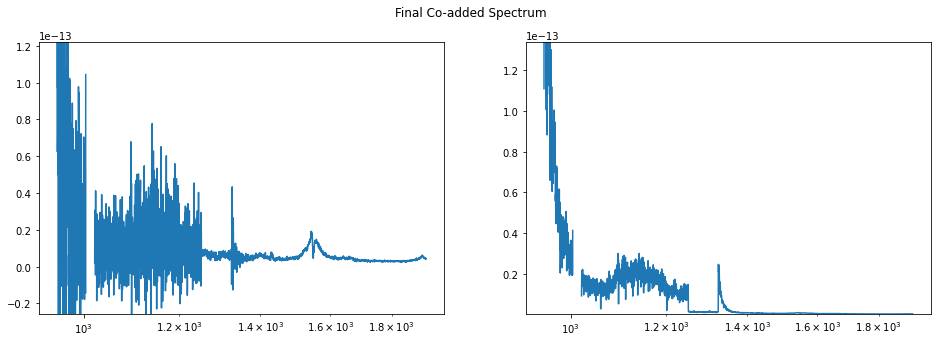

Good: J21377-1432


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J21435+1743 is not viable.
SNR is 2.244396


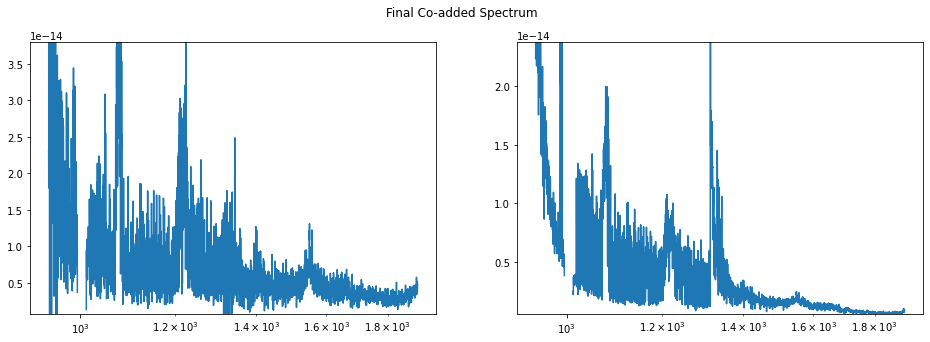

Good: J21435+1743


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 11.172797


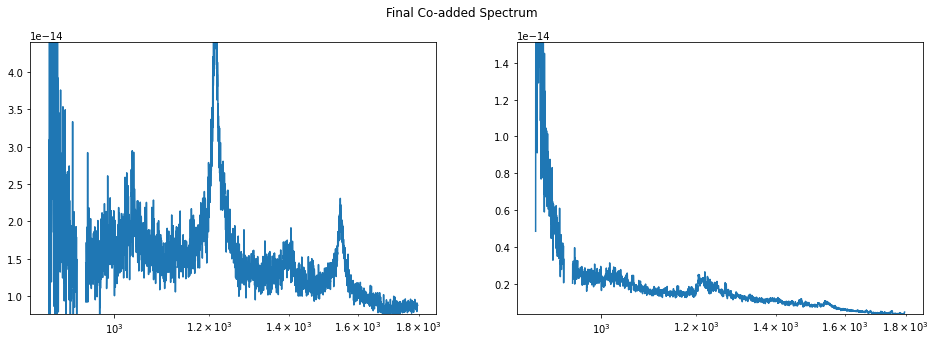

Good: J22032+3145
Median wavelength resolution: 69.09 km/s
SNR is 9.650989


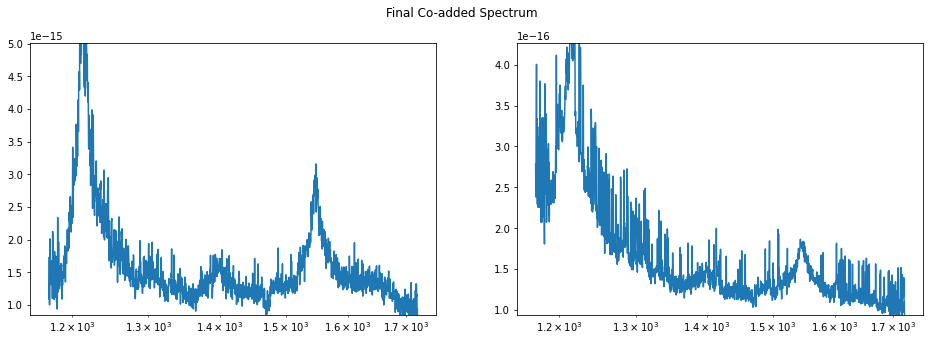

Good: J22188-0335


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 44.698345


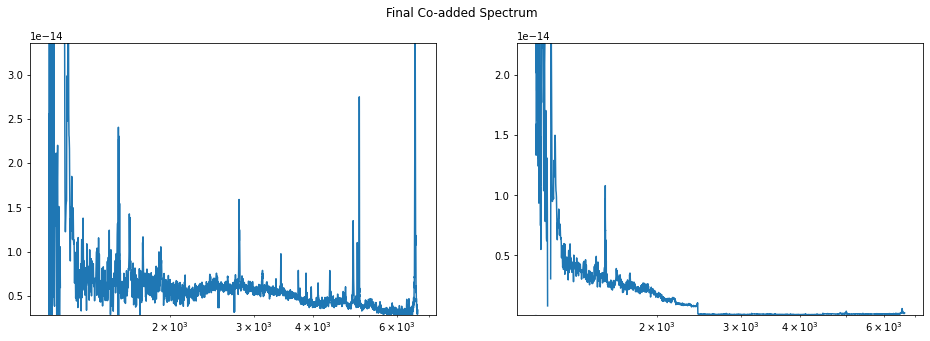

Good: UGC12163


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J22463-1206 is not viable.
SNR is 3.813951


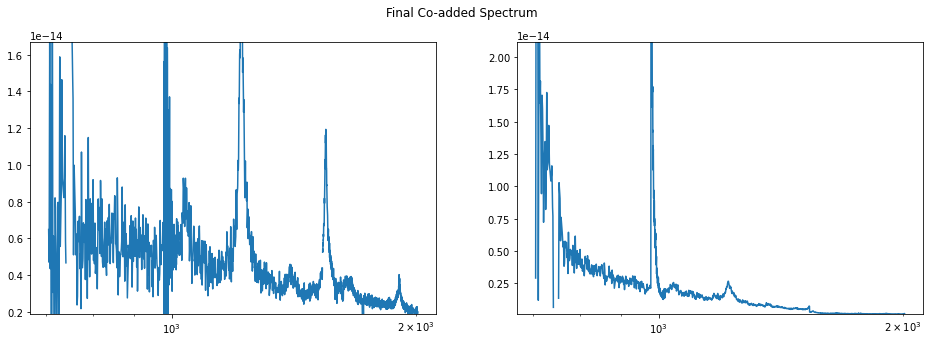

Good: J22463-1206
Median wavelength resolution: 69.09 km/s
SNR is 21.165722


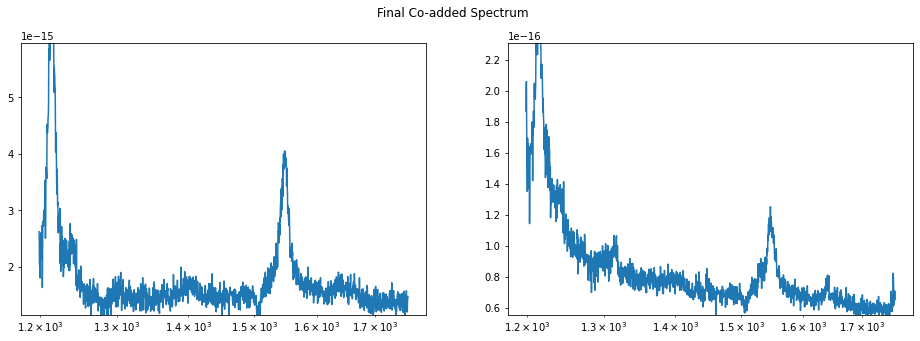

Good: 3C454


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J22541+1136 is not viable.
SNR is 6.437907


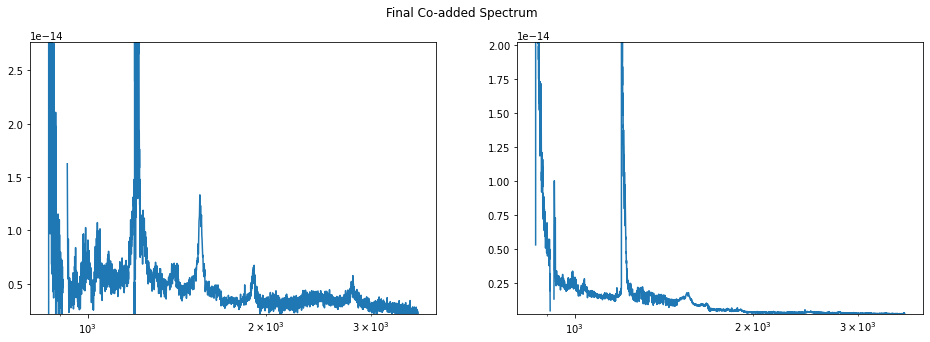

Good: J22541+1136


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J23037-6807 is not viable.
SNR is 2.667890


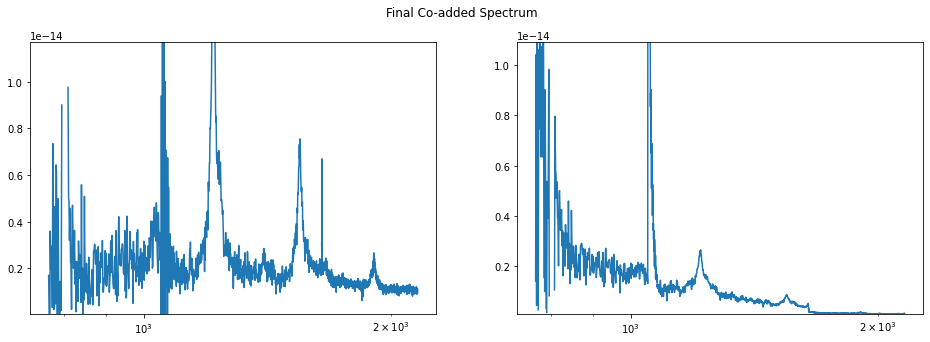

Good: J23037-6807


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 12.692320


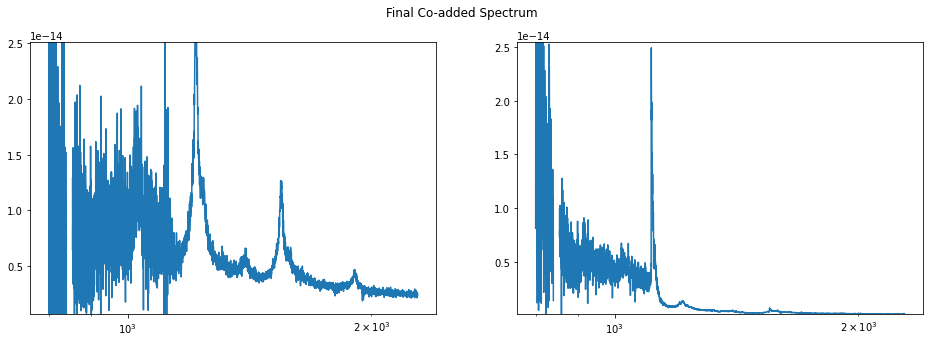

Good: J23112+1008


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for J23466+0930 is not viable.
SNR is 3.449036


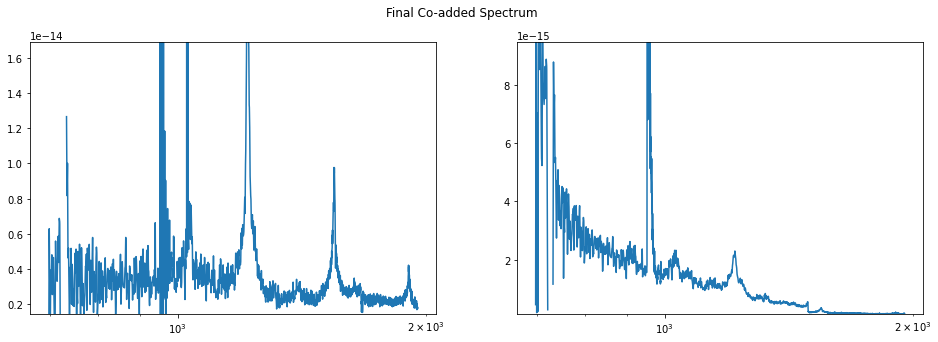

Good: J23466+0930
Median wavelength resolution: 69.09 km/s
Coadd for J23519-0109 is not viable.
SNR is 6.736750


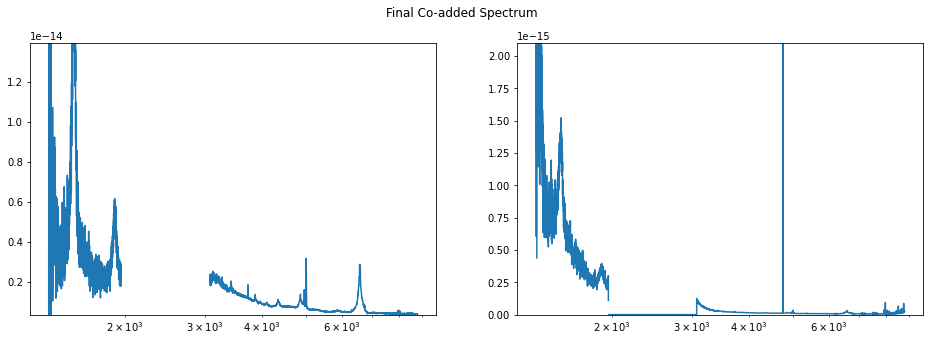

Good: J23519-0109


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 7.420637


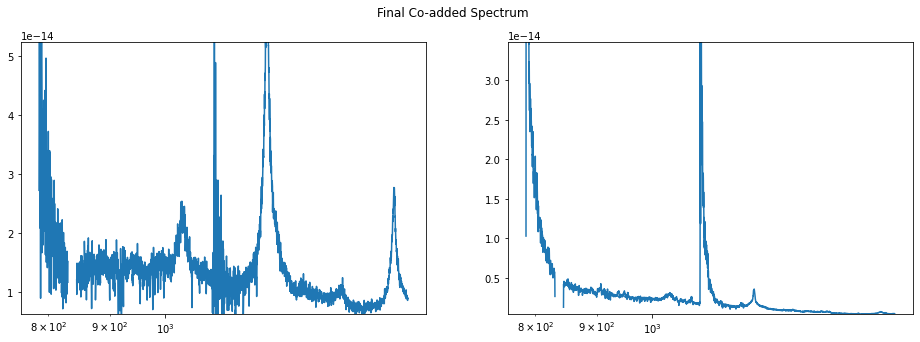

Good: PG0003+158
BAD!: PG0953+414


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 12.430818


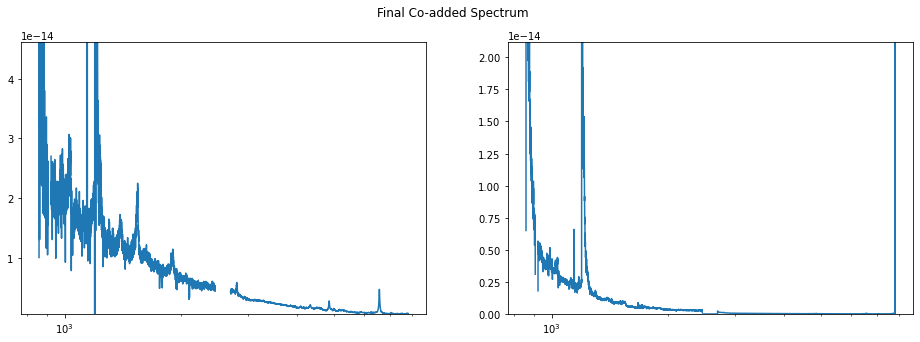

Good: PG1001+291
Median wavelength resolution: 69.09 km/s
SNR is 13.588187


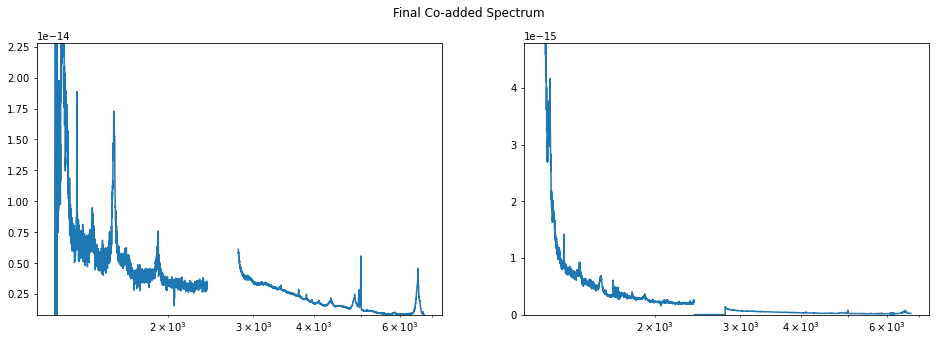

Good: PG1049-005
Median wavelength resolution: 69.09 km/s
SNR is 17.146419


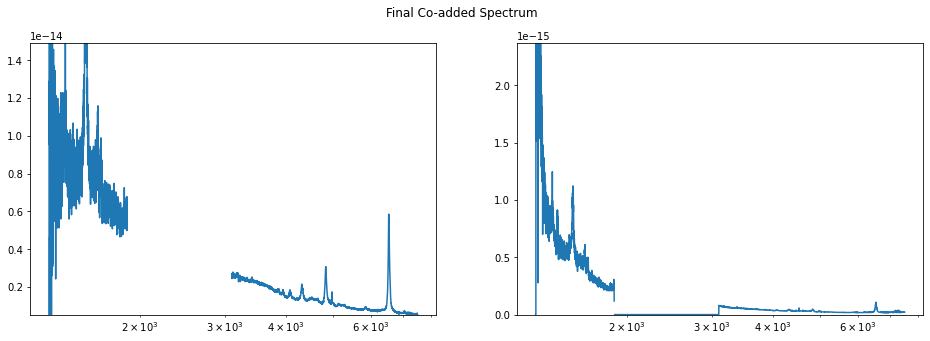

Good: PG1121+422


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 8.600134


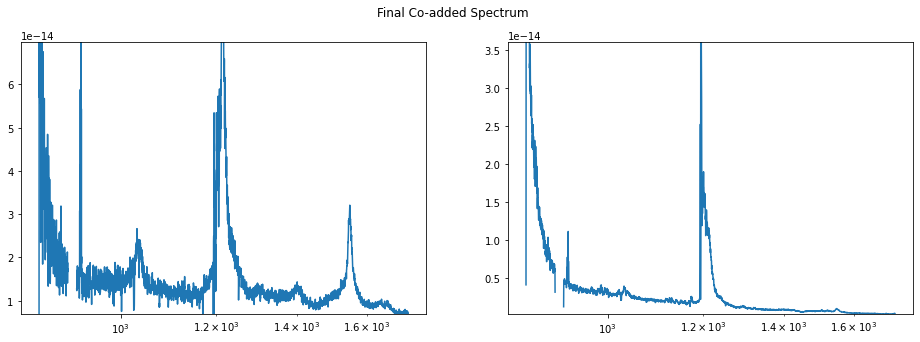

Good: PG1216+069


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 15.317708


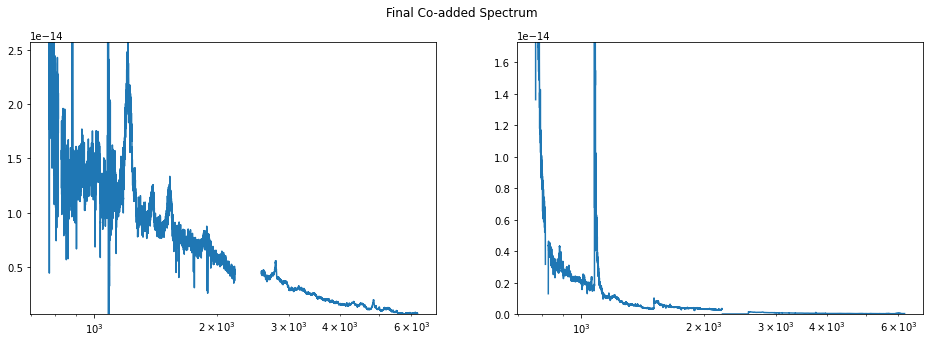

Good: SBS1259+593


In [12]:
#%%capture
for i in range(sul[FOS].shape[0]):
    if sdss[FOS][i]: fn_sdss = "%04d/spec-%04d-%05d-%04d.fits"%(plate[FOS][i],plate[FOS][i],mjd[FOS][i],fiber[FOS][i])
    else: fn_sdss = None
    try:
        Read_FOS_TVM.rebin(id_fos[FOS][i], fn_sdss, z[FOS][i])
        print("Good: %s" % id_fos[FOS][i])
    except IndexError:
        print("BAD!: %s" % id_fos[FOS][i])
        #except ValueError:
        #    print("%s doesn't work"%id_fos[FOS][i])

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 10.443768


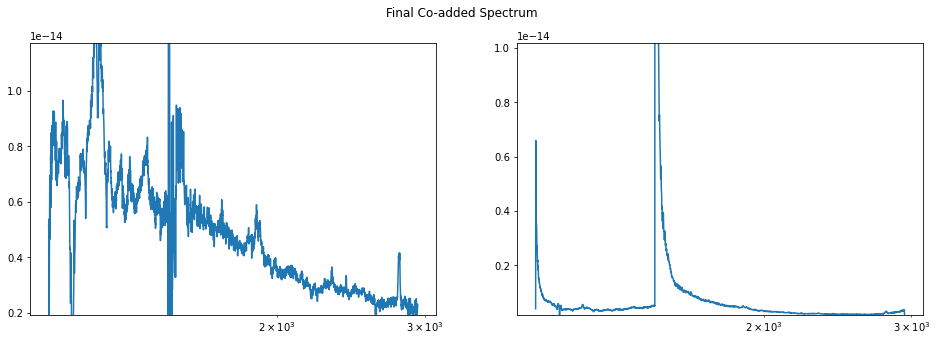

Good: J13253-3824


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Volumes/MyPassportforMac/HST/AllHSTCode/LowerResHSTRebin_TVM.py:99: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_HST_rebin[i] = (m_err*wave_HST_rebin[i] + b_err) * np.sqrt(old_width/new_width)


Median wavelength resolution: 69.09 km/s
SNR is 11.195910


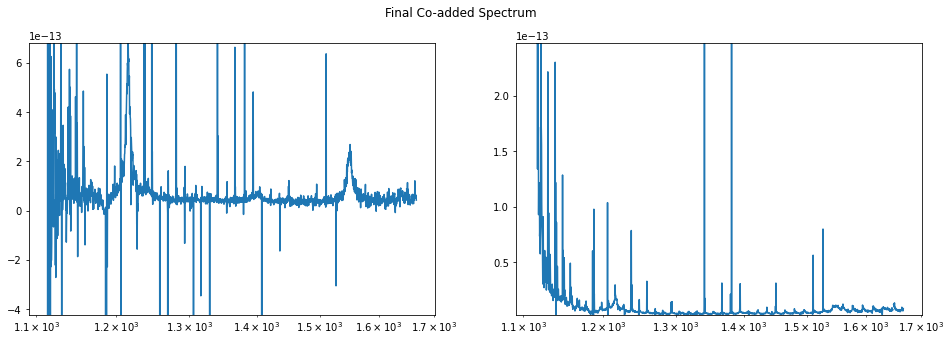

Good: Mrk335


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Value Error: NGC3516
Median wavelength resolution: 69.09 km/s
SNR is 71.356641


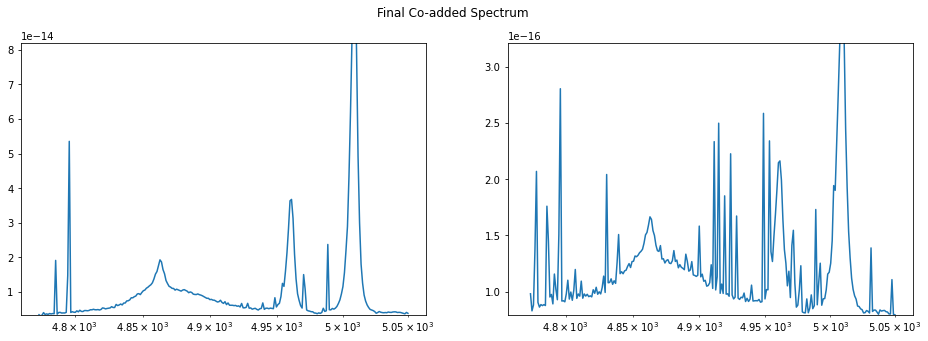

Good: NGC3783


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for NGC4395 is not viable.
SNR is 4.429267


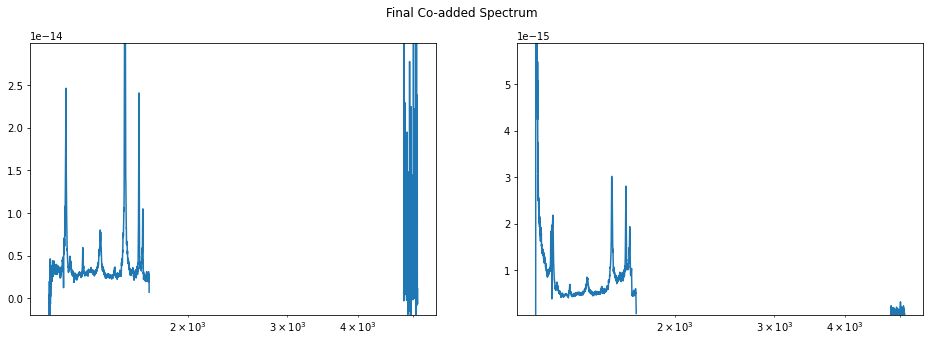

Good: NGC4395
Index Error: NGC5548


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Volumes/MyPassportforMac/HST/AllHSTCode/LowerResHSTRebin_TVM.py:99: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_HST_rebin[i] = (m_err*wave_HST_rebin[i] + b_err) * np.sqrt(old_width/new_width)


Median wavelength resolution: 69.09 km/s
Coadd for NGC7469 is not viable.
SNR is 6.763525


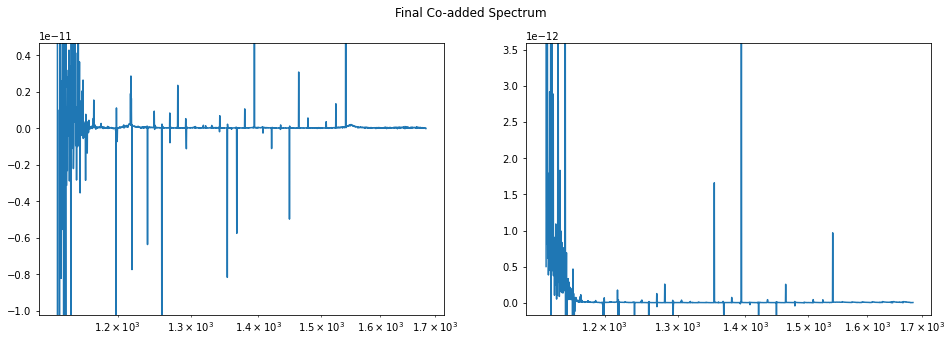

Good: NGC7469
Value Error: PG0026+129


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 18.364795


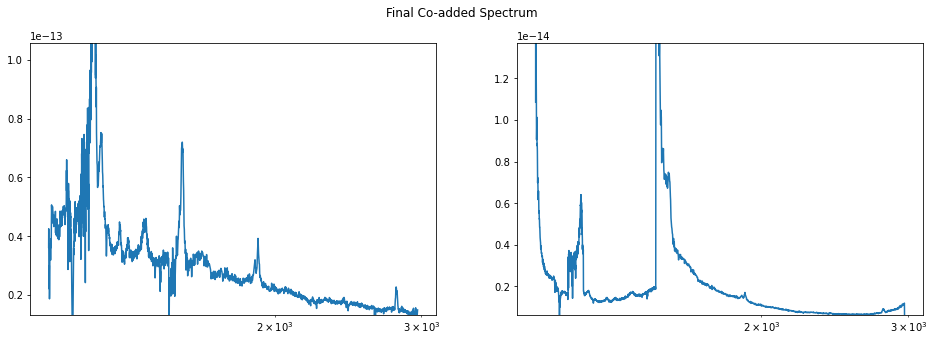

Good: TONS180
Median wavelength resolution: 69.09 km/s
SNR is 8.697894


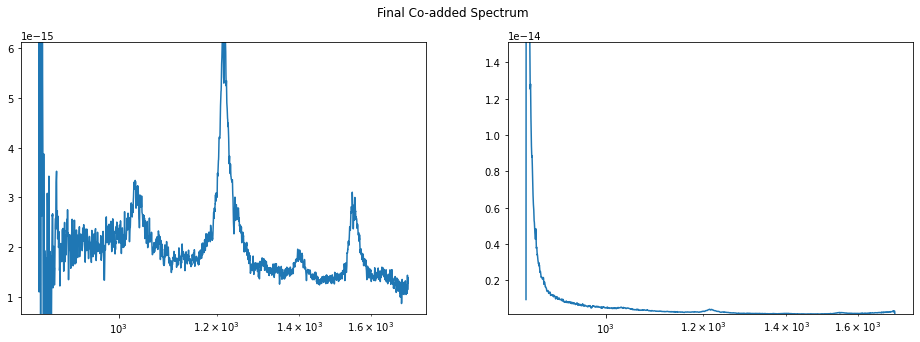

Good: J01376-2430


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for NGC1275 is not viable.
SNR is 0.026269


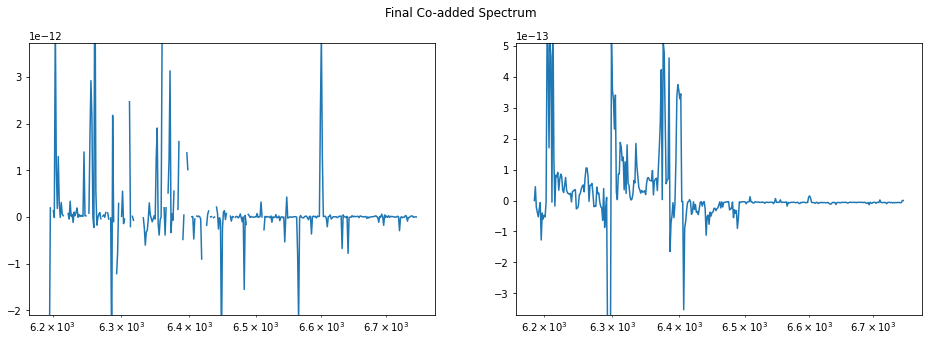

Good: NGC1275
Median wavelength resolution: 69.09 km/s
Coadd for J04232-0120 is not viable.
SNR is 6.643614


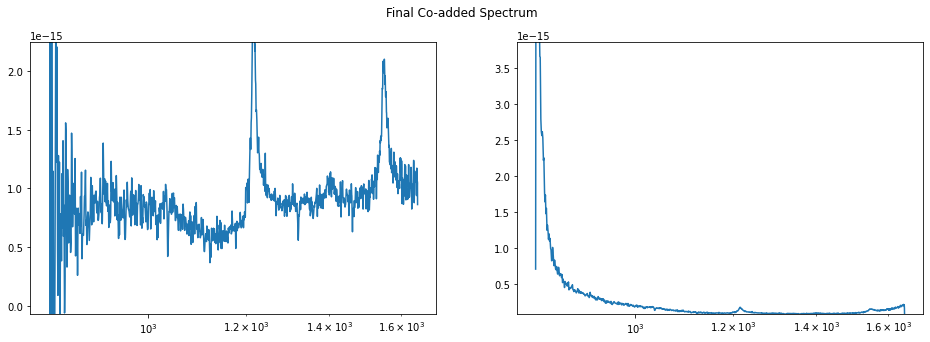

Good: J04232-0120
Index Error: PICTORA


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 17.863860


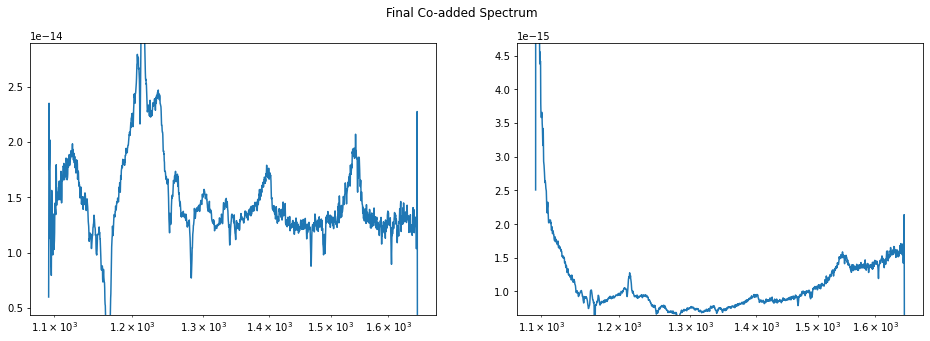

Good: J07086-4933


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Value Error: NGC3227
Index Error: PG1211+143
Median wavelength resolution: 69.09 km/s
Coadd for NGC4253 is not viable.
SNR is 2.865623


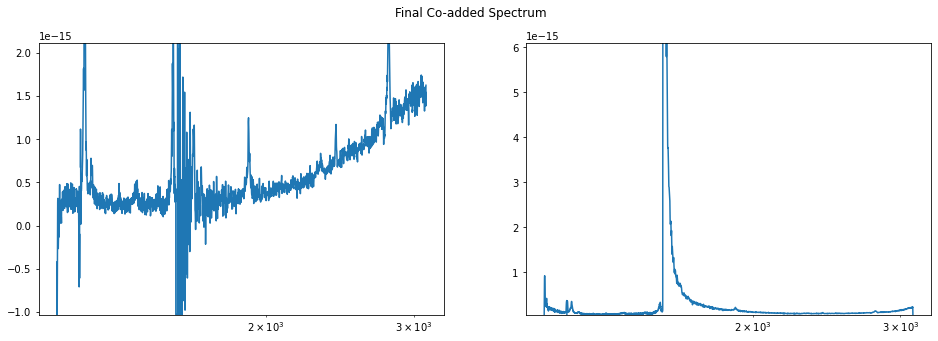

Good: NGC4253


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Volumes/MyPassportforMac/HST/AllHSTCode/LowerResHSTRebin_TVM.py:99: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_HST_rebin[i] = (m_err*wave_HST_rebin[i] + b_err) * np.sqrt(old_width/new_width)


Median wavelength resolution: 69.09 km/s
SNR is 8.865041


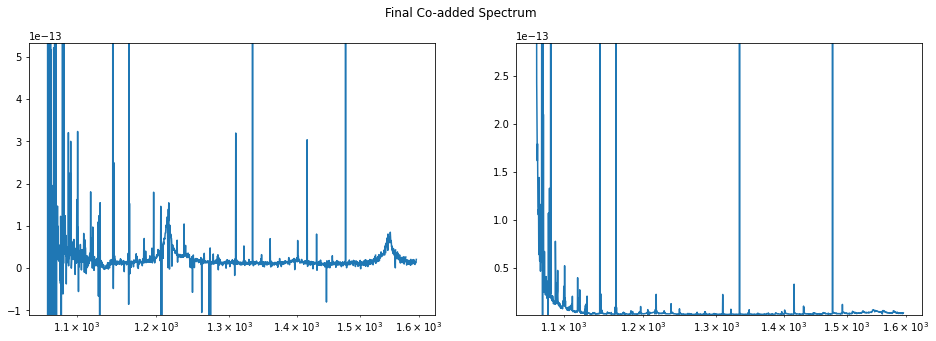

Good: Mrk205
Value Error: 3C273
Median wavelength resolution: 69.09 km/s
SNR is 12.207756


/Volumes/MyPassportforMac/HST/AllHSTCode/Read_STIS_TVM.py:360: RuntimeWarning: divide by zero encountered in true_divide
  sdss_fluxerr = (1/(np.sqrt(hdulist[1].data["ivar"])))*10**-17 #rest-frame flux uncertainty


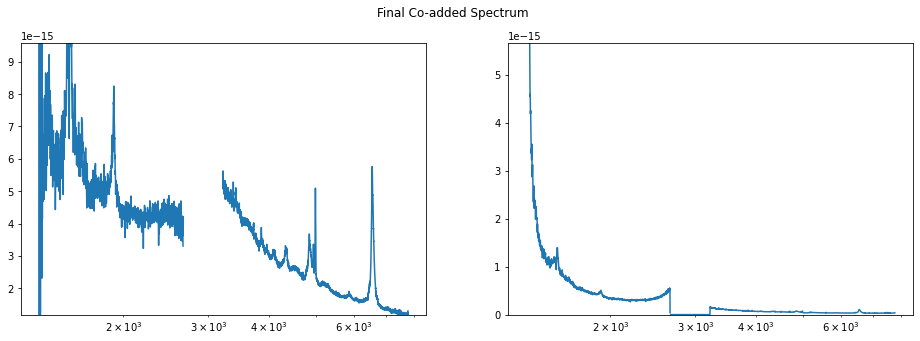

Good: J13122+3515


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 12.897280


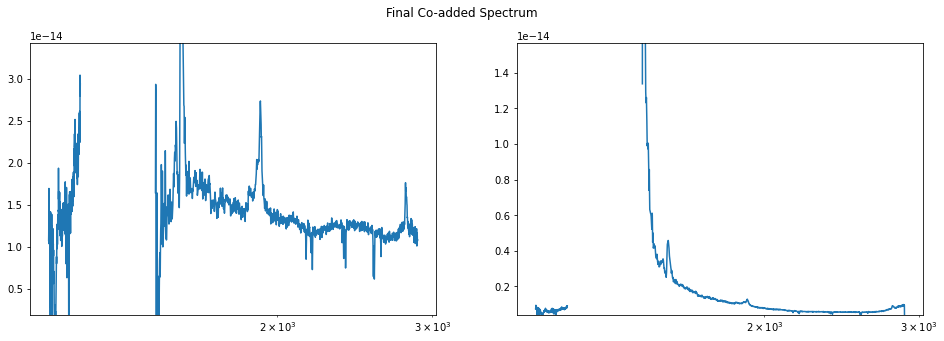

Good: PG1351+640


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 8.201714


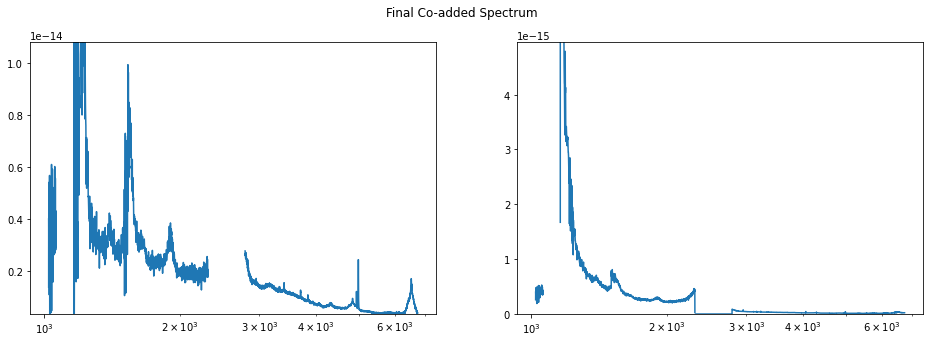

Good: B21425+26


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Volumes/MyPassportforMac/HST/AllHSTCode/LowerResHSTRebin_TVM.py:99: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_HST_rebin[i] = (m_err*wave_HST_rebin[i] + b_err) * np.sqrt(old_width/new_width)


Median wavelength resolution: 69.09 km/s
Coadd for PG1444+407 is not viable.
SNR is 6.557388


/Volumes/MyPassportforMac/HST/AllHSTCode/Read_STIS_TVM.py:360: RuntimeWarning: divide by zero encountered in true_divide
  sdss_fluxerr = (1/(np.sqrt(hdulist[1].data["ivar"])))*10**-17 #rest-frame flux uncertainty


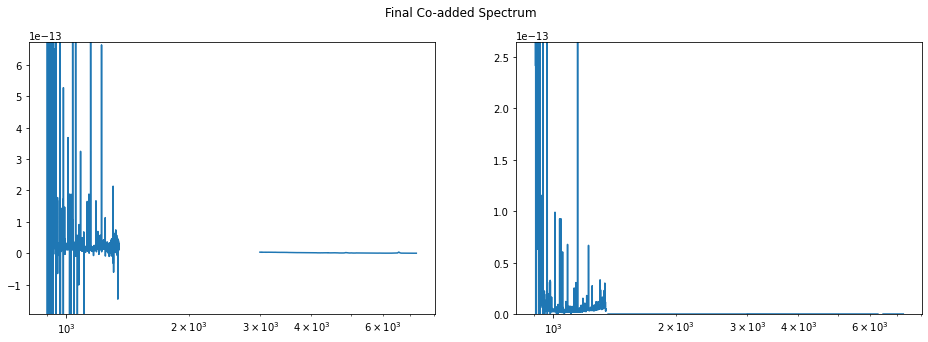

Good: PG1444+407


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 14.746835


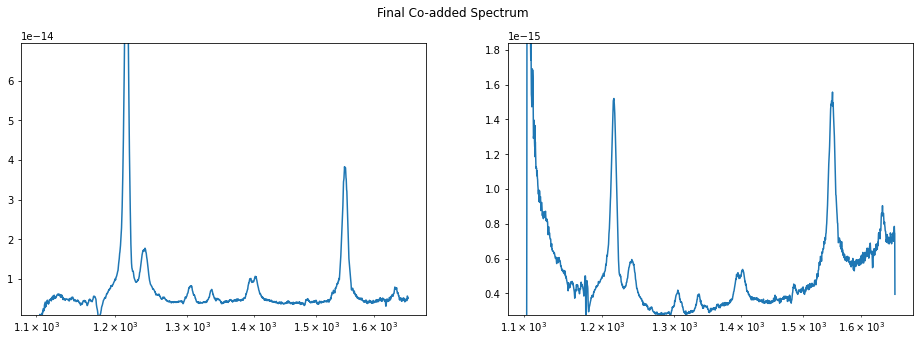

Good: J15591+3501
Median wavelength resolution: 69.09 km/s
SNR is 10.665797


/Volumes/MyPassportforMac/HST/AllHSTCode/Read_STIS_TVM.py:360: RuntimeWarning: divide by zero encountered in true_divide
  sdss_fluxerr = (1/(np.sqrt(hdulist[1].data["ivar"])))*10**-17 #rest-frame flux uncertainty


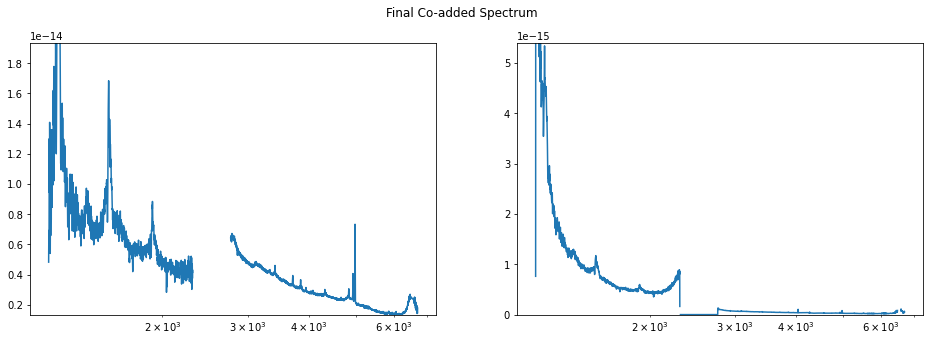

Good: SBS1704+608


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 16.004640


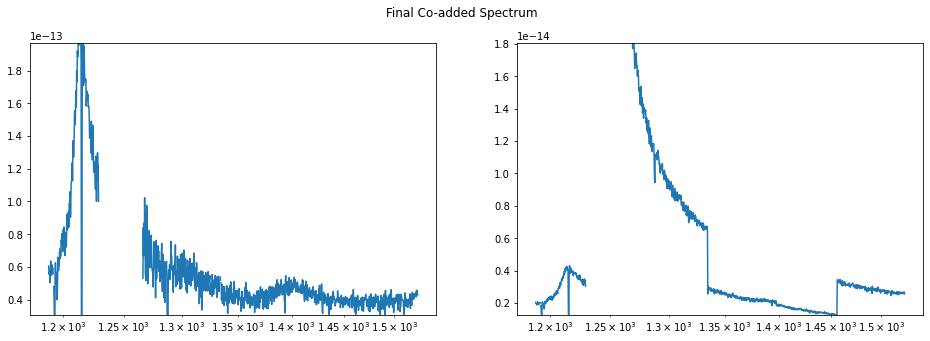

Good: J18219+6420
Value Error: 3C390


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 24.427238


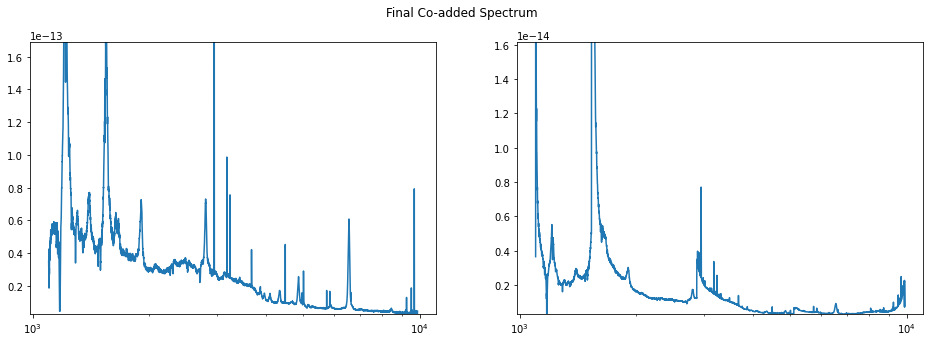

Good: Mrk509


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 8.223691


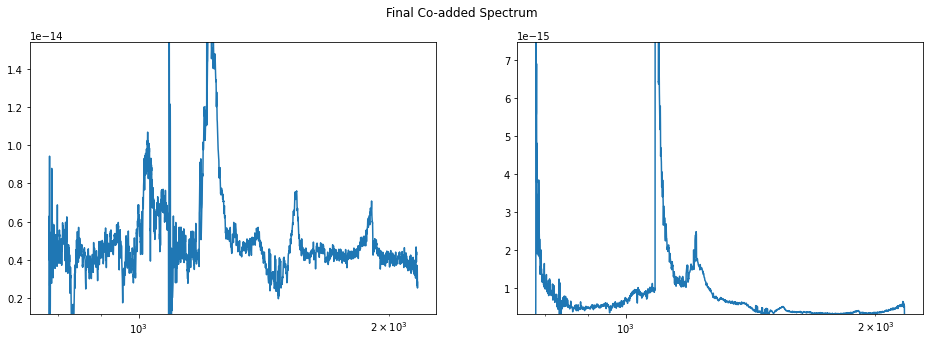

Good: J21148+0607
Median wavelength resolution: 69.09 km/s
SNR is 7.786454


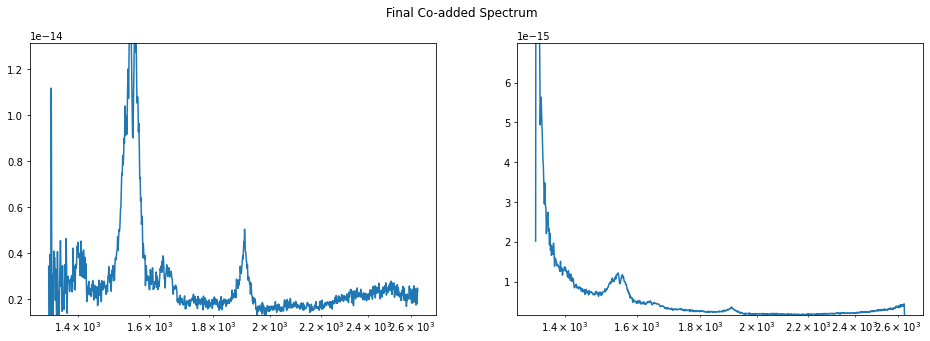

Good: J21377-1432


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 10.129178


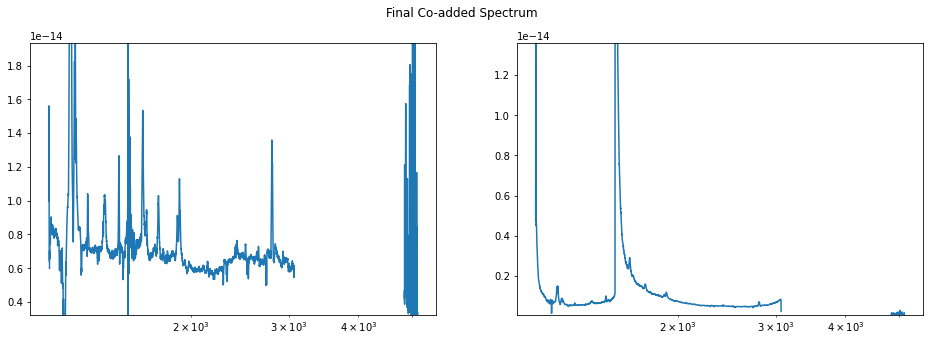

Good: UGC12163


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 7.773105


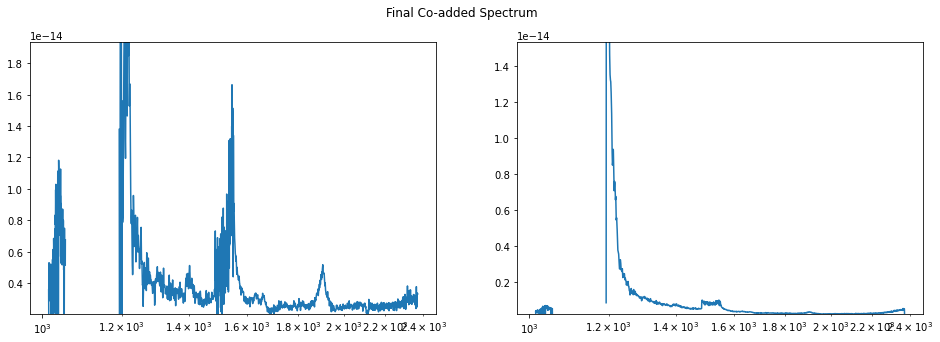

Good: J22541+1136


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Value Error: PG0953+414
Median wavelength resolution: 69.09 km/s
Coadd for SBS1259+593 is not viable.
SNR is 4.442797


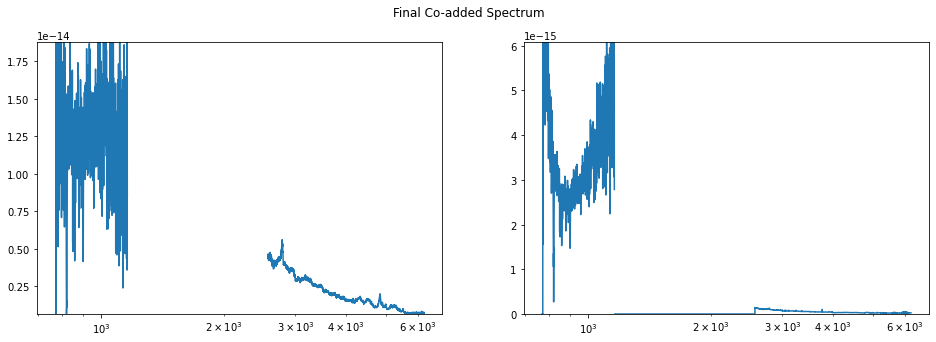

Good: SBS1259+593


In [12]:
#%%capture
for i in range(sul[STIS].shape[0]):
    if sdss[STIS][i]: fn_sdss = "%04d/spec-%04d-%05d-%04d.fits"%(plate[STIS][i],plate[STIS][i],mjd[STIS][i],fiber[STIS][i])
    else: fn_sdss = None
    try:
        Read_STIS_TVM.rebin(id_stis[STIS][i], fn_sdss, z[STIS][i])
        print("Good: %s" % id_stis[STIS][i])
    except IndexError:
        print("Index Error: %s" % id_stis[STIS][i])
        #except ValueError:
        #    print("%s doesn't work"%id_stis[STIS][i])
    except ValueError:
        print("Value Error: %s" % id_stis[STIS][i])

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 7.524249


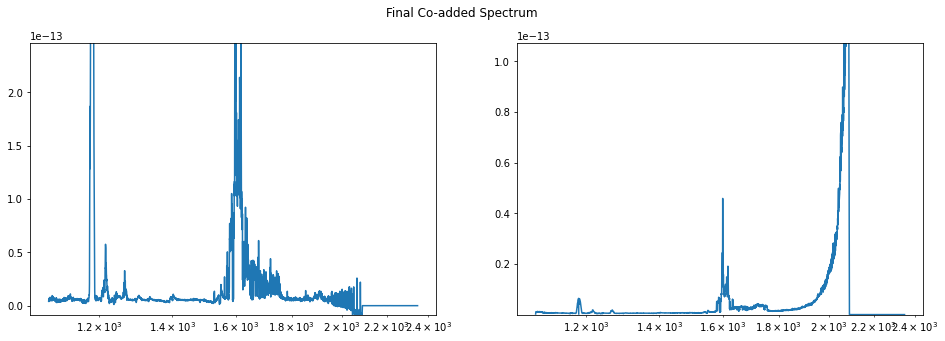

Good: J00392-5117


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 8.473063


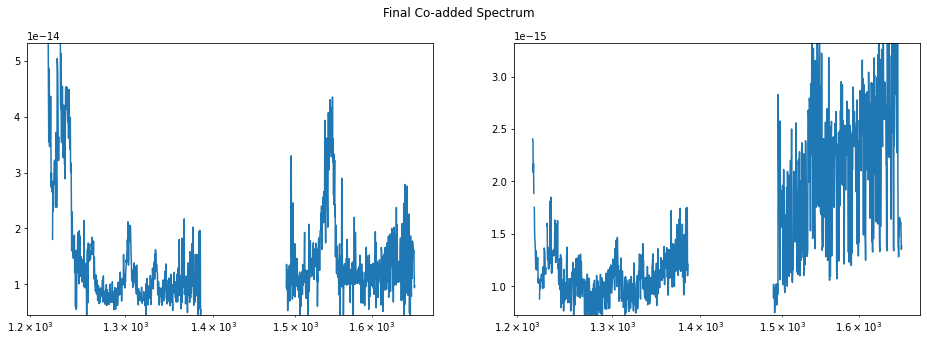

Good: J00535+1241


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 13.967270


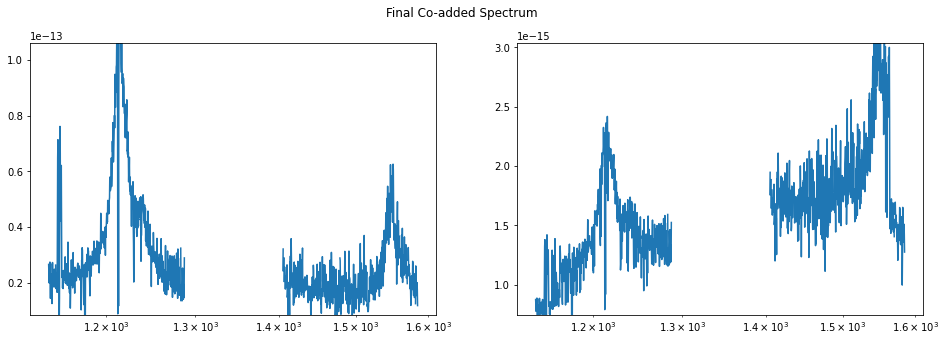

Good: J16279+5522


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 32.062663


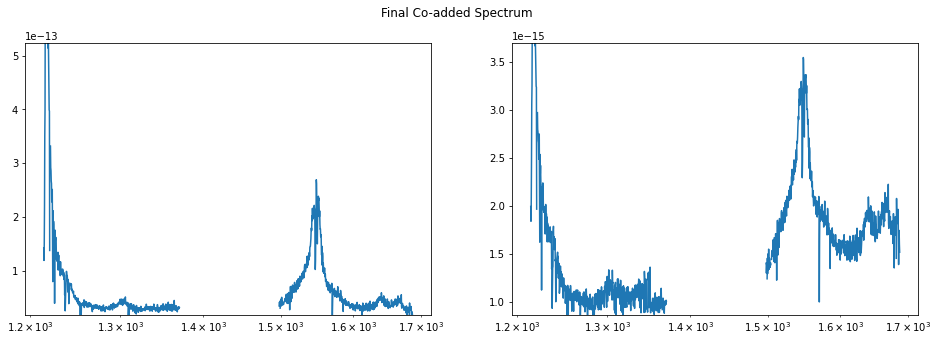

Good: MR2251-178


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for NGC4395 is not viable.
SNR is 2.360700


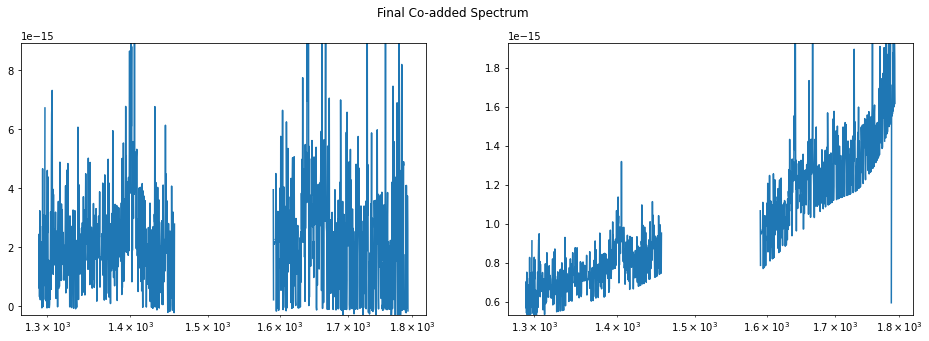

Good: NGC4395


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 17.928784


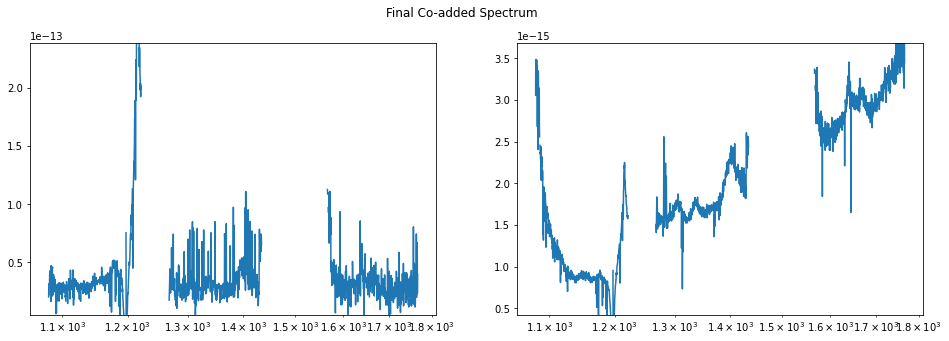

Good: NGC7469


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 11.208529


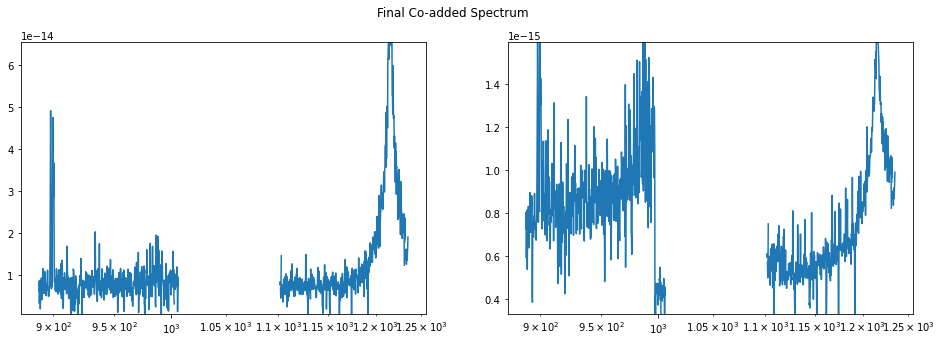

Good: PG0003+158


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 28.714027


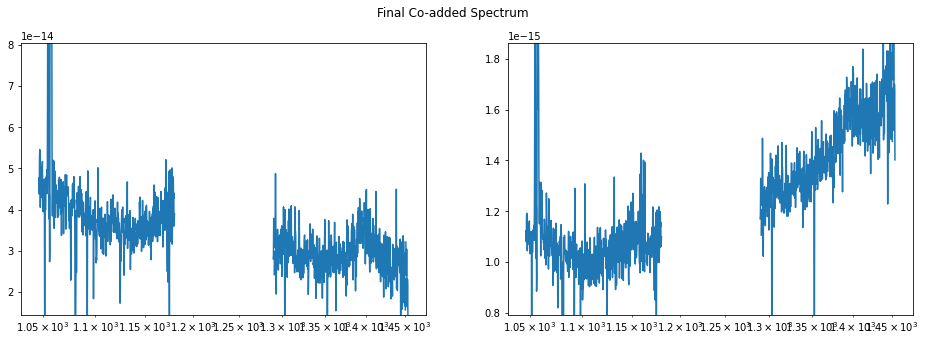

Good: PG0953+414


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 12.714586


/Volumes/MyPassportforMac/HST/AllHSTCode/Read_COS_TVM.py:359: RuntimeWarning: divide by zero encountered in true_divide
  sdss_fluxerr = (1/(np.sqrt(hdulist[1].data["ivar"])))*10**-17 #rest-frame flux uncertainty


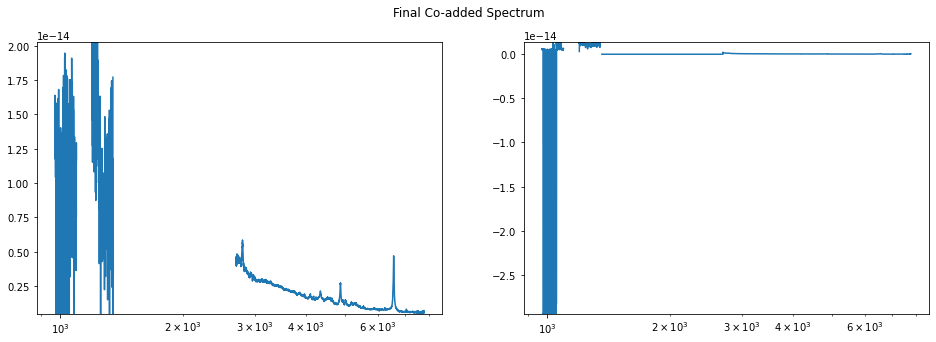

Good: PG1001+291


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
Coadd for PG1049-005 is not viable.
SNR is 4.213509


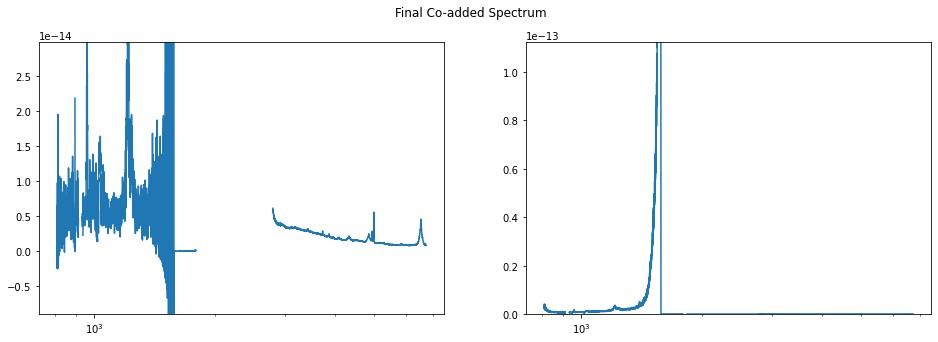

Good: PG1049-005


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 11.562636


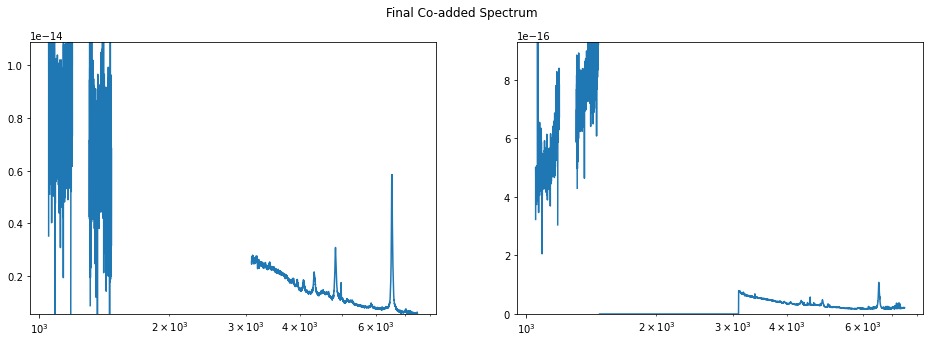

Good: PG1121+422


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 19.522432


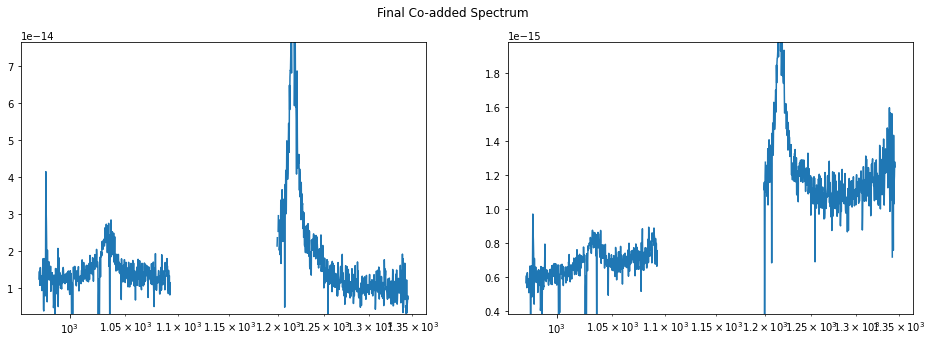

Good: PG1216+069


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Median wavelength resolution: 69.09 km/s
SNR is 27.107579


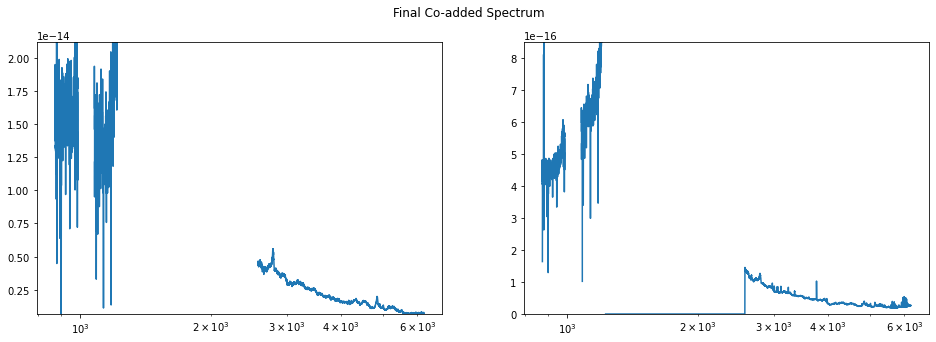

Good: PG1259+593


In [12]:
#%%capture
for i in range(sul[COS].shape[0]):
    if sdss[COS][i]: fn_sdss = "%04d/spec-%04d-%05d-%04d.fits"%(plate[COS][i],plate[COS][i],mjd[COS][i],fiber[COS][i])
    else: fn_sdss = None
    try:
        Read_COS_TVM.rebin(id_cos[COS][i], fn_sdss, z[COS][i])
        print("Good: %s" % id_cos[COS][i])
    except IndexError:
        print("Index Error: %s" % id_cos[COS][i])
        #except ValueError:
        #    print("%s doesn't work"%id_cos[COS][i])
    except ValueError:
        print("Value Error: %s" % id_cos[COS][i])

In [13]:
pd.read_csv("/Volumes/MyPassportforMac/HST/AllData/SulenticAllData/COS/NGC5548/all_exposures.txt", sep="\s+")

Flag   Rootname Target Name          RA        DEC  PropID   PI Name  \
0       1  lcao47n9q    NGC-5548  214.498062  25.136789   13330  Peterson   
1       1  lcao39jxq    NGC-5548  214.498062  25.136789   13330  Peterson   
2       1  lcao2myoq    NGC-5548  214.498062  25.136789   13330  Peterson   
3       1  lcao2lsqq    NGC-5548  214.498062  25.136789   13330  Peterson   
4       1  lc7003aaq    NGC-5548  214.498062  25.136789   13184   Kaastra   
..    ...        ...         ...         ...        ...     ...       ...   
590     1  lcao0vb8q    NGC-5548  214.498062  25.136789   13330  Peterson   
591     1  lc7002czq    NGC-5548  214.498062  25.136789   13184   Kaastra   
592     1  lcao46heq    NGC-5548  214.498062  25.136789   13330  Peterson   
593     1  lcao1mb7q    NGC-5548  214.498062  25.136789   13330  Peterson   
594     1  lcao2negq    NGC-5548  214.498062  25.136789   13330  Peterson   

    Detector Segment  LP Grating  Cenwave  FPPOS     Exptime   Nevents  \
0        FUV    BOTH   2   G130M     1291      3  200.031998  456022.0   
1        FUV    BOTH   2   G160M     1600      1  588.031982  488160.0   
2        FUV    BOTH   2   G130M     1327      3  200.000000  501457.0   
3        FUV    BOTH   2   G130M     1291      3  200.031998  446918.0   
4        FUV    BOTH   2   G130M     1327      4  450.015991  915904.0   
..       ...     ...  ..     ...      ...    ...         ...       ...   
590      FUV    BOTH   2   G160M     1600      1  588.031982  735467.0   
591      FUV    BOTH   2   G160M     1623      1  550.015991  415979.0   
592      FUV    BOTH   2   G160M     1623      2  588.992004  516894.0   
593      FUV    BOTH   2   G160M     1600      1  588.031982  877214.0   
594      FUV    BOTH   2   G160M     1600      1  588.000000  640241.0   

        Mean Flux   Median Flux        Date  \
0    4.824720e-14  3.693836e-14  2014-03-19   
1    3.543873e-14  2.741863e-14  2014-03-11   
2    5.478718e-14  4.257210e-14  2014-07-11   
3    5.541459e-14  4.163068e-14  2014-07-10   
4    5.091030e-14  4.211154e-14  2013-07-24   
..            ...           ...         ...   
590  5.442138e-14  4.769563e-14  2014-05-30   
591  3.319448e-14  2.564730e-14  2013-07-12   
592  4.008016e-14  3.065299e-14  2014-03-18   
593  6.595023e-14  5.826791e-14  2014-06-16   
594  4.757175e-14  3.864204e-14  2014-07-12   

                            Target Description  
0         GALAXY;ACCRETIONDISK;BLR;NLR;SEYFERT  
1         GALAXY;ACCRETIONDISK;BLR;NLR;SEYFERT  
2         GALAXY;ACCRETIONDISK;BLR;NLR;SEYFERT  
3         GALAXY;ACCRETIONDISK;BLR;NLR;SEYFERT  
4    GALAXY;ACCRETIONDISK;NUCLEUS;SEYFERT;WIND  
..                                         ...  
590       GALAXY;ACCRETIONDISK;BLR;NLR;SEYFERT  
591  GALAXY;ACCRETIONDISK;NUCLEUS;SEYFERT;WIND  
592       GALAXY;ACCRETIONDISK;BLR;NLR;SEYFERT  
593       GALAXY;ACCRETIONDISK;BLR;NLR;SEYFERT  
594       GALAXY;ACCRETIONDISK;BLR;NLR;SEYFERT  

[595 rows x 19 columns]

Generally seems to be doing pretty good for now.  Now do some testing on individual spectra that seem to be causing problems.  I suspect the two main issues are probably (1) accidentally saving data from two instruments for a target and trying to combine them, and (2) the rebinning being off the spectrum's SDSS scale by ~1 pixel in a few special cases.  

If we have decent coverage from other observations in a target, I'm just going to cut the single exposure causing problems.  Should also do a sort of quality control check and cut individual exposures with crappy S/N.

In [26]:
np.isnan((sul.iloc[id_fos=="J06357-7516"])["SDSS_NAME"].values[0])

True

In [28]:
ID = sul.iloc[id_fos=="J06357-7516"]
ID

IAU Instrument     FOS_Name STIS_Name COS_Name HST_Opt      z  \
38  J06357-7516        FOS  J06357-7516      None     None     NaN  0.651   

    Hbeta  F1550  FCIVNC  ...       _RA        _DE  SDSS Spectra  SDSS_NAME  \
38   7922   2.42    1.12  ...  98.94381 -75.271317           yes        NaN   

    RA  DEC  PLATE  MJD  FIBERID  Separation  
38 NaN  NaN    NaN  NaN      NaN         NaN  

[1 rows x 29 columns]

Median wavelength resolution: 69.09 km/s
SNR is 11.120697


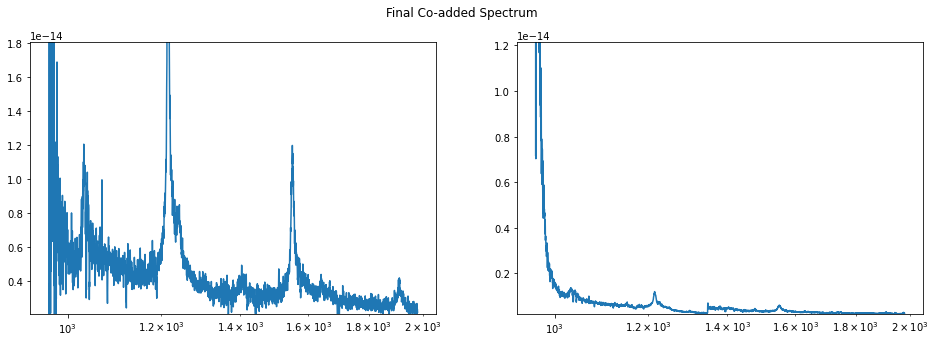

Good: J06357-7516


In [31]:
ID = sul.iloc[id_fos=="J06357-7516"]
fn_sdss = None if np.isnan(ID["SDSS_NAME"].values[0]) else ID["SDSS_NAME"].values[0]

try:
    Read_FOS_TVM.rebin(ID["FOS_Name"].values[0], fn_sdss, ID["z"].values[0])
    print("Good: %s" % ID["FOS_Name"].values[0])
except IndexError:
    print("Index Error: %s" % ID["FOS_Name"].values[0])
    #except ValueError:
    #    print("%s doesn't work"%ID["FOS_Name"].values[0])
except ValueError:
    print("Index Error: %s" % ID["FOS_Name"].values[0])

Fixed by removing single G160L observation that was shorter than the rest anyway.  Mask array length was different from error array length when loading in data for some reason?

----

In [30]:
Read_FOS_TVM.rebin(ID["FOS_Name"].values[0], fn_sdss, ID["z"].values[0])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2064 but corresponding boolean dimension is 792